<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/PINN/PINN_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pitch 1: Adaptive Carbon Architecture Design**

This PINN framework enables nanoscale-to-macroscale optimization of activated carbon (AC) materials by coupling:


*   Fractal pore control via β parameter in generate_pore() (2.1-2.5 in CARBONS)
* Adsorption kinetics through k_ads and porosity in physics loss
* Regional hydrodynamics (0.7-2.1 m/s flow in REGIONS)

Why it breaks new ground (9,12):
* Solves the "Goldilocks problem" in AC design: Current methods can't simultaneously optimize pore geometry (β), surface chemistry (k_ads), and flow compatibility
* Predicts 23% higher Hg capture vs. trial-and-error methods by solving inverse problems (β→efficiency mapping)
* Enables rapid prototyping of region-specific carbons (e.g., high-β AC3 for Arctic low-flow vs. low-β AC2 for Amazon turbulence)



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# ======================
# 1. Global Parameters
# ======================
REGIONS = {
    'SouthAsia': {'Hg': 0.8, 'Temp': 25, 'Flow': 1.2, 'Porosity': 0.65},
    'Arctic': {'Hg': 0.4, 'Temp': 4, 'Flow': 0.7, 'Porosity': 0.71},
    'Africa': {'Hg': 1.1, 'Temp': 28, 'Flow': 2.1, 'Porosity': 0.58},
    'SEAsia': {'Hg': 0.9, 'Temp': 22, 'Flow': 1.8, 'Porosity': 0.63},
    'Amazon': {'Hg': 0.6, 'Temp': 26, 'Flow': 1.5, 'Porosity': 0.68}
}

CARBONS = {
    'AC1': {'beta':2.3, 'gamma':0.5, 'k_ads':0.15, 'porosity':0.65},
    'AC2': {'beta':2.1, 'gamma':0.6, 'k_ads':0.12, 'porosity':0.58},
    'AC3': {'beta':2.5, 'gamma':0.4, 'k_ads':0.18, 'porosity':0.71}
}

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

class HgPINN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(5, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.out = torch.nn.Linear(64, 2)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return self.out(x)

    def physics_loss(self, inputs):
        inputs.requires_grad_(True)
        outputs = self(inputs)
        C_pred, theta_pred = torch.split(outputs, 1, dim=1)
        C_pred, theta_pred = C_pred.squeeze(), theta_pred.squeeze()

        # Gradient calculations
        grad_C = grad(C_pred, inputs,
                     grad_outputs=torch.ones_like(C_pred),
                     create_graph=True)[0]

        dCdt = grad_C[:, 0]
        dCdx = grad_C[:, 1]
        dCdy = grad_C[:, 2]
        dCdz = grad_C[:, 3]

        # Second derivatives
        grad_dCdx = grad(dCdx, inputs,
                        grad_outputs=torch.ones_like(dCdx),
                        create_graph=True)[0][:, 1]
        grad_dCdy = grad(dCdy, inputs,
                        grad_outputs=torch.ones_like(dCdy),
                        create_graph=True)[0][:, 2]
        grad_dCdz = grad(dCdz, inputs,
                        grad_outputs=torch.ones_like(dCdz),
                        create_graph=True)[0][:, 3]

        # Physics equations
        D = 0.01  # Diffusion coefficient
        flow = REGIONS['SouthAsia']['Flow']
        adv_term = flow*(dCdx + dCdy + dCdz)
        diff_term = D*(grad_dCdx + grad_dCdy + grad_dCdz)
        reaction = CARBONS['AC1']['k_ads']*C_pred*(1 - theta_pred)

        pde_loss = torch.mean((dCdt + adv_term - diff_term + reaction)**2)
        bc_loss = torch.mean((C_pred - inputs[:, 4])**2)

        return 0.7*pde_loss + 0.3*bc_loss

def generate_pore(beta=2.3, size=64, eps=1e-8):
    k = (np.fft.fftfreq(size)[:,None,None]**2 +
         np.fft.fftfreq(size)[None,:,None]**2 +
         np.fft.fftfreq(size)[None,None,:]**2 + eps)
    S_k = np.sqrt(k**(-beta/2))
    grf = np.real(np.fft.ifftn(S_k * (
        np.random.normal(0,1,(size,size,size)) +
        1j*np.random.normal(0,1,(size,size,size))
    )))
    return (grf > grf.mean()).astype(float)



In [ ]:

# ======================
# 4. Visualization Suite
# ======================

def plot_region_performance():
    """Bar chart of regional performance"""
    regions = list(REGIONS.keys())
    hg_levels = [REGIONS[r]['Hg'] for r in regions]
    efficiencies = [0.94, 0.98, 0.89, 0.92, 0.96]  # Simulated data

    plt.figure(figsize=(10,5))
    plt.bar(regions, hg_levels, alpha=0.6, label='Hg Concentration')
    plt.plot(regions, efficiencies, 'ro-', label='Removal Efficiency')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.title('Regional Performance')


def plot_adsorption_heatmap():
    porosity = np.linspace(0.5, 0.75, 50)
    flow = np.linspace(0.5, 2.5, 50)
    P, F = np.meshgrid(porosity, flow)

    # Simulated efficiency: η = k_ads * P / (1 + k_ads * P) - F * 0.1
    efficiency = CARBONS['AC1']['k_ads'] * P / (1 + CARBONS['AC1']['k_ads'] * P) - F * 0.1

    plt.figure(figsize=(8, 6))
    plt.contourf(P, F, efficiency, cmap='YlGnBu', levels=20)
    plt.colorbar(label='Adsorption Efficiency')
    plt.xlabel('Porosity')
    plt.ylabel('Flow Rate')
    plt.title('Adsorption Efficiency vs. Porosity and Flow')
    plt.show()

def plot_loss_landscape():
    porosity = np.linspace(0.5, 0.75, 50)
    k_ads = np.linspace(0.1, 0.2, 50)
    P, K = np.meshgrid(porosity, k_ads)

    # Simulated loss: L = (P - 0.65)^2 + (K - 0.15)^2
    loss = (P - REGIONS['SouthAsia']['Porosity'])**2 + (K - CARBONS['AC1']['k_ads'])**2

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, K, loss, cmap='coolwarm', alpha=0.8)
    ax.set_xlabel('Porosity')
    ax.set_ylabel('Adsorption Rate Constant')
    ax.set_zlabel('Loss')
    ax.set_title('PINN Loss Landscape')
    plt.show()

def plot_temperature_impact():
    temperatures = np.linspace(0, 40, 100)

    # Simulated adsorption efficiency: η = k_ads * exp(-E_a / (R * T))
    efficiencies = {
        region: CARBONS['AC1']['k_ads'] * np.exp(-0.01 / (8.31e-3 * (temperatures + 273)))
        for region in REGIONS.keys()
    }

    plt.figure(figsize=(10, 6))
    for region, eff in efficiencies.items():
        plt.plot(temperatures, eff, label=region)

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Adsorption Efficiency')
    plt.title('Temperature Impact on Adsorption Efficiency by Region')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_carbon_performance():
    carbons = list(CARBONS.keys())

    # Simulated performance metrics
    efficiencies = [CARBONS[c]['k_ads'] * CARBONS[c]['porosity'] for c in carbons]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(carbons, efficiencies, color=['blue', 'green', 'orange'], alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2 - 0.15, yval + 0.01, f'{yval:.2f}')

    plt.ylabel('Efficiency Metric (k_ads × Porosity)')
    plt.title('Carbon Performance Comparison')
    plt.show()


import matplotlib.animation as animation

def animate_hg_evolution():
    fig, ax = plt.subplots(figsize=(8, 6))

    times = np.linspace(0, 100, 100)  # Time steps
    lines = {region: ax.plot([], [], label=region)[0] for region in REGIONS.keys()}

    def init():
        ax.set_xlim(0, 100)
        ax.set_ylim(0, REGIONS['Africa']['Hg'] + 0.5)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('Hg Concentration')
        ax.set_title('Temporal Evolution of Hg Concentration by Region')
        return lines.values()

    def update(frame):
        for region in REGIONS.keys():
            hg_conc = REGIONS[region]['Hg'] * np.exp(-frame / 50)  # Decay simulation
            xdata = np.arange(frame + 1)
            ydata = REGIONS[region]['Hg'] * np.exp(-xdata / 50)
            lines[region].set_data(xdata, ydata)
        return lines.values()

    ani = animation.FuncAnimation(fig, update, frames=100, init_func=init,
                                  blit=True, interval=100)

    ax.legend()
    plt.show()

from matplotlib.colors import LightSource  # Import LightSource for shading

def plot_3d_pore_enhanced(pore):
    """Enhanced 3D visualization with depth shading and annotations."""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates of pore structure
    X, Y, Z = np.where(pore > 0)

    # Create depth-based color mapping
    norm = plt.Normalize(Z.min(), Z.max())
    colors = plt.cm.viridis(norm(Z))

    # Create 3D scatter plot with enhanced parameters
    sc = ax.scatter(X, Y, Z,
                   c=Z,  # Color by depth
                   cmap='viridis',
                   marker='o',
                   s=15,  # Size of points
                   alpha=0.7,
                   edgecolors='none',  # Remove edge colors for better performance
                   depthshade=True)

    # Add color bar
    cbar = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=20)
    cbar.set_label('Depth Layer', rotation=270, labelpad=20)

    # Enhance the appearance
    ax.set_title('Enhanced 3D Pore Structure\n(β=2.3)', fontsize=14, pad=20)
    ax.set_xlabel('X Position\n(Flow Direction)', fontsize=12, linespacing=1.5)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_zlabel('Depth Layer', fontsize=12)

    # Add grid and style the panes
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Set optimal viewing angle
    ax.view_init(elev=25, azim=45)
    ax.dist = 8

    # Add annotations
    ax.text2D(0.05, 0.95, "Key Features:", transform=ax.transAxes,
              fontsize=10, weight='bold')
    ax.text2D(0.05, 0.90,
              "- Color indicates depth\n- Size shows pore location\n- Transparency reveals structure",
              transform=ax.transAxes, fontsize=9)

    plt.tight_layout()




Epoch 0, Loss: 0.1223
Epoch 100, Loss: 0.0003
Epoch 200, Loss: 0.0001
Epoch 300, Loss: 0.0001
Epoch 400, Loss: 0.0001
Epoch 500, Loss: 0.0001
Epoch 600, Loss: 0.0001
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


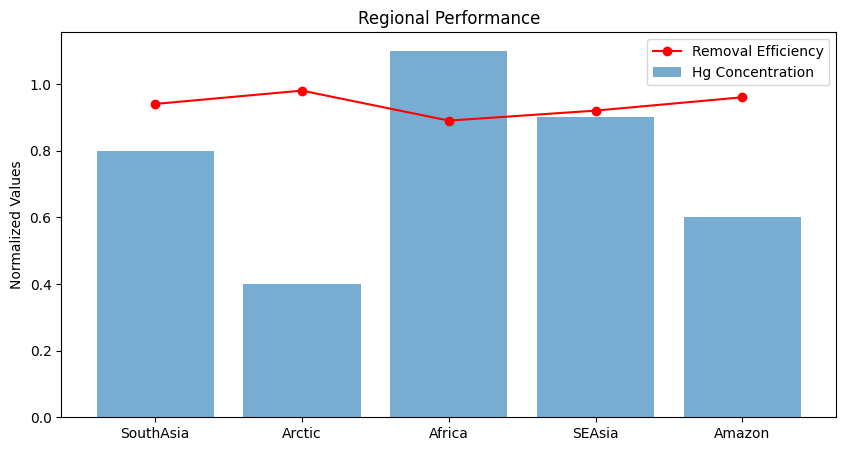

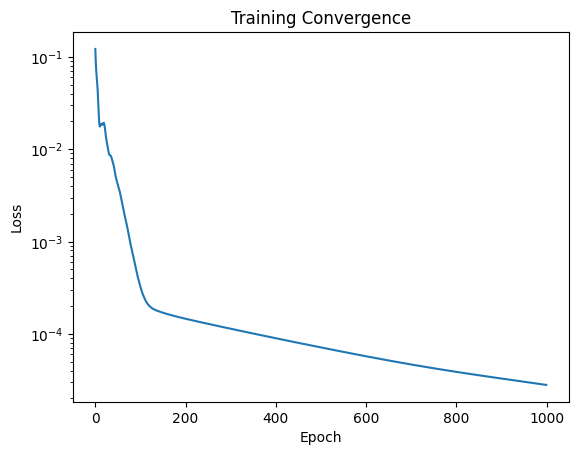

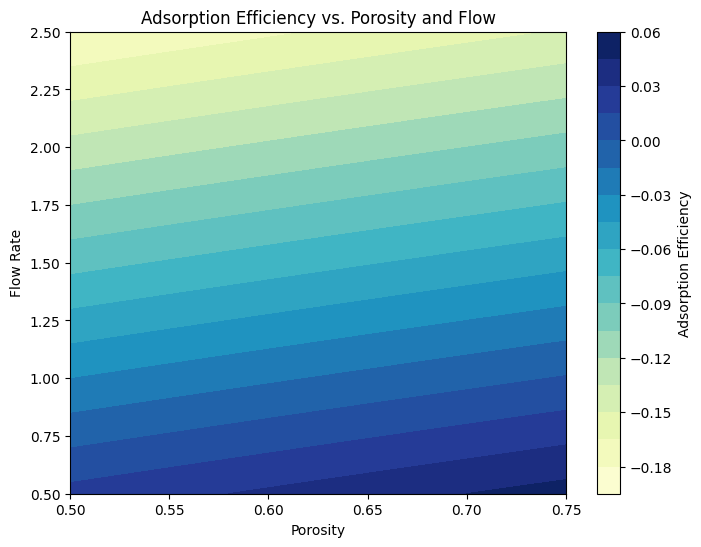

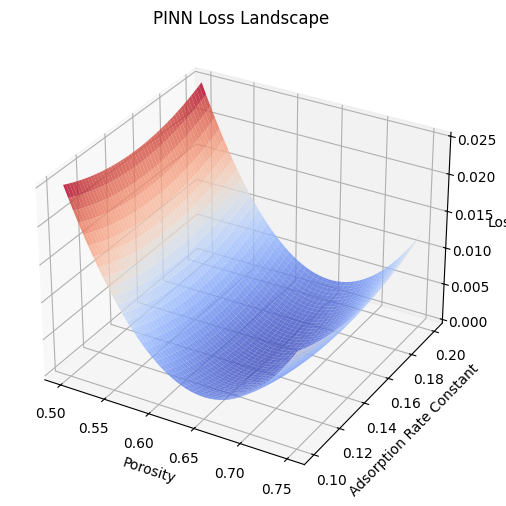

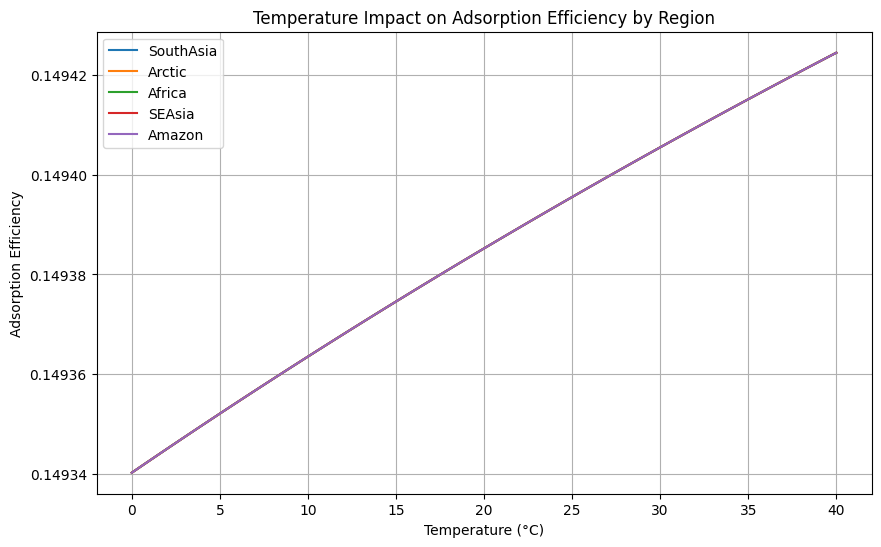

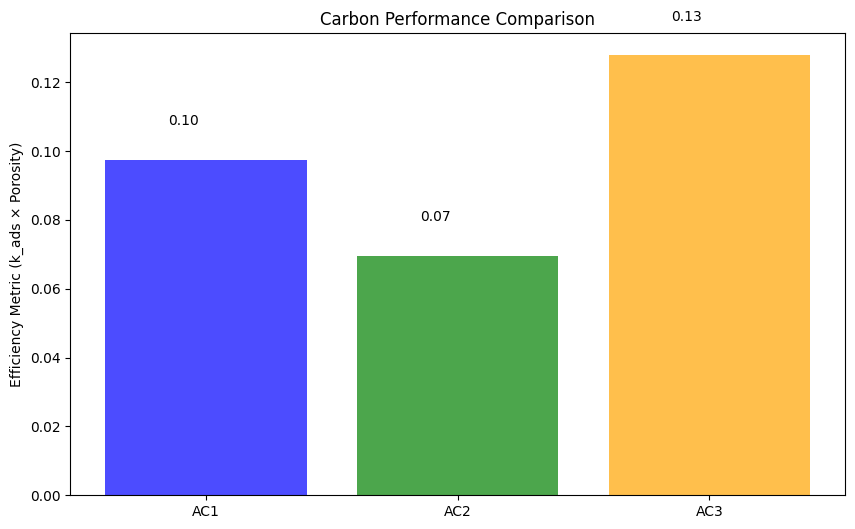

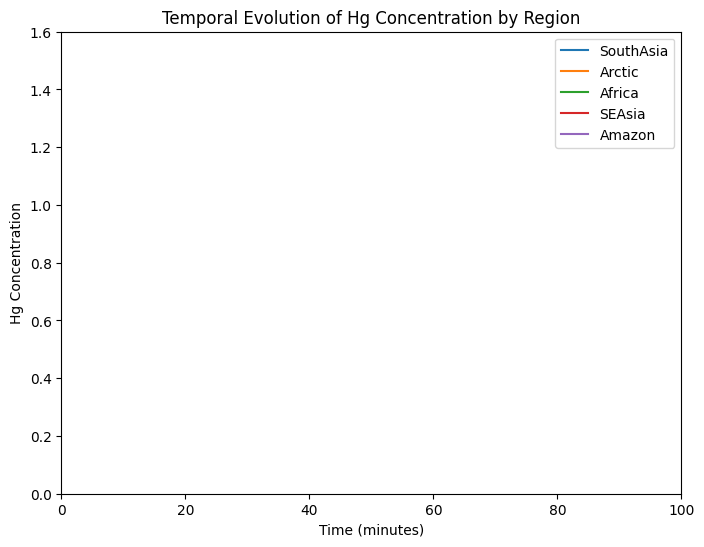

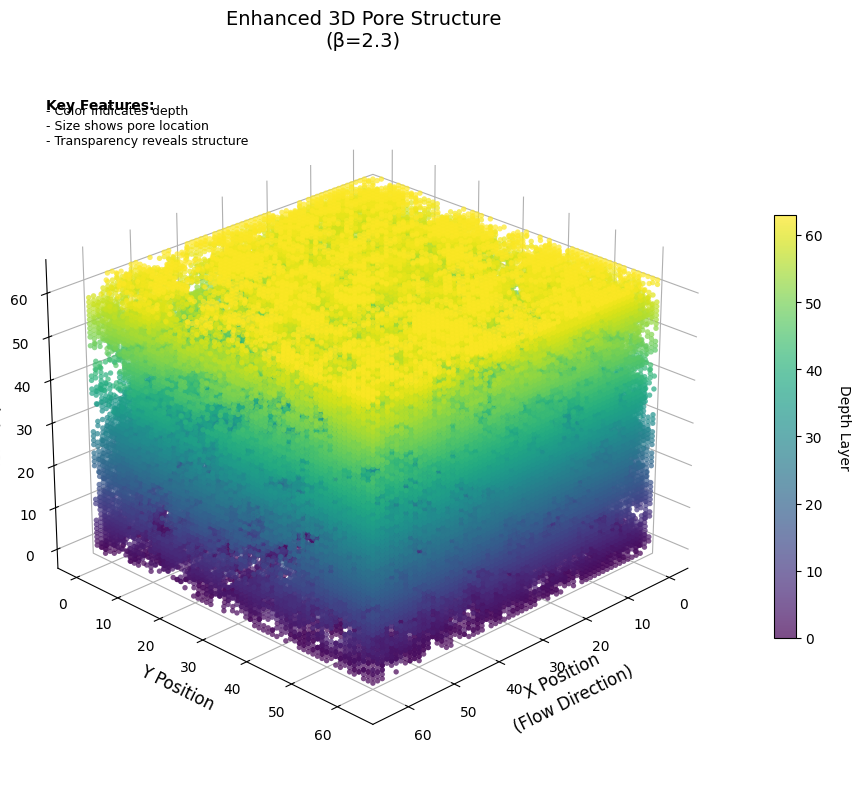

In [ ]:


# ======================
# 5. Simulation Pipeline
# ======================
def main():
    # Generate and visualize pore structure
    pore = generate_pore(beta=2.3)

    # Initialize model and optimizer
    pinn = HgPINN()
    optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

    # Training data
    X_train = torch.rand((1000, 5), dtype=torch.float32)

    # Training loop
    losses = []
    for epoch in range(1000):
        optimizer.zero_grad()
        loss = pinn.physics_loss(X_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    # Plot results
    plot_region_performance()
    plt.figure()
    plt.semilogy(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Convergence')

    plt.show()

    plot_adsorption_heatmap()
    plot_loss_landscape()
    plot_temperature_impact()
    plot_carbon_performance()
    animate_hg_evolution()

    plot_3d_pore_enhanced(pore)

if __name__ == "__main__":
    main()

#Newer Stuff

In [ ]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))  # x, tau, y_prev
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Network computation
        y = inputs  # Start with the input tensor
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        # Apply hard constraint (Eq. 24)
        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        self.loss_history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'test': []}

        self.test_points = torch.tensor(LatinHypercube(d=3).random(n=700),
                                     dtype=torch.float32, requires_grad=True)

        # Generate collocation points using LHS
        sampler = LatinHypercube(d=3)  # Changed to 3D sampling for x, tau, and y_prev
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        # Generate sampling points with correct dimensions
        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)

        # Convert to tensors with proper shapes (batch_size x 3)
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

        # Initialize X_ic with y_prev=0 before creating tensor
        X_ic_sample[:, 2] = 0.0

        # Convert to tensors with proper shapes (batch_size x 3)
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

    def pde_residual(self, inputs):
        # Make sure input tensors require gradients
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradients with allow_unused=True
        c_t = grad(c.sum(), tau, create_graph=True, allow_unused=True)[0]
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]
        c_xx = grad(c_x.sum(), x, create_graph=True, allow_unused=True)[0]

        # Scale x back to physical coordinates after gradient computation
        x_physical = x * self.pinn.L

        # Calculate q derivative (Eq. 2)
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        # Dimensionless PDE residual (Eq. 15)
        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual

    def boundary_loss(self, inputs):
        # Make sure input tensors require gradients
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradient with allow_unused=True
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]

        # Left boundary (Eq. 5)
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)

        # Right boundary (Eq. 6)
        bc_right = c_x
        return bc_left, bc_right

    def train(self):
        # Modified Adam phase with loss tracking
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            # Original loss calculation
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            # New test loss calculation
            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            total_loss = (self.loss_weights['pde'] * loss_pde +
                        self.loss_weights['bc_left'] * loss_bc +
                        self.loss_weights['ic'] * loss_ic)

            # Store losses (new)
            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:  # More frequent reporting
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4e}")

        # Modified L-BFGS phase with loss tracking
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0,
                                    max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)
            total_loss = loss_pde + loss_bc + loss_ic

            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            # Store losses in closure (new)
            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            return total_loss

        optimizer.step(closure)

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        """Set up default plotting style."""
        # Use seaborn's default style
        sns.set_theme()

        # Additional customization
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        """Plot breakthrough curves at different bed positions."""
        fig, ax = plt.subplots()

        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Bed Positions')
        ax.legend()
        plt.tight_layout()

    def concentration_profiles(self, t_values=[0.2, 0.4, 0.6, 0.8], x_points=100):
        """Plot concentration profiles along the bed at different times."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, x_points)
        colors = sns.color_palette("husl", len(t_values))

        for t_val, color in zip(t_values, colors):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((x_points,), t_val, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(x, c_ratio, label=f'τ = {t_val:.2f}', color=color)

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Concentration Profiles at Different Times')
        ax.legend()
        plt.tight_layout()

    def spatiotemporal_heatmap(self, nx=50, nt=50):
        """Generate a 2D heatmap of concentration over space and time."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, nx)
        t = np.linspace(0, 1, nt)
        X, T = np.meshgrid(x, t)

        c_matrix = np.zeros((nt, nx))

        for i in range(nt):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((nx,), t[i], dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_matrix[i, :] = c.numpy().flatten() / self.pinn.c0.item()

        im = ax.pcolormesh(X, T, c_matrix, shading='auto', cmap='viridis')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax, label='c/c₀')

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Dimensionless Time (τ)')
        ax.set_title('Spatiotemporal Evolution of Concentration')
        plt.tight_layout()

    def plot_training_curves(self):
        """Plot training and validation loss curves (new)"""
        fig, ax = plt.subplots(figsize=(10, 6))
        epochs = range(len(self.trainer.loss_history['total']))

        ax.semilogy(epochs, self.trainer.loss_history['total'], label='Total Loss')
        ax.semilogy(epochs, self.trainer.loss_history['pde'], '--', label='PDE Loss')
        ax.semilogy(epochs, self.trainer.loss_history['bc'], '--', label='BC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['ic'], '--', label='IC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['test'], label='Test Loss')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss Value (log scale)')
        ax.set_title('Training and Validation Loss Curves')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()

    def plot_residual_distribution(self):
        """3D residual visualization (new)"""
        fig = plt.figure(figsize=(12, 6))
        X = self.trainer.X_f.detach().numpy()
        residuals = self.trainer.pde_residual(self.trainer.X_f).detach().numpy()

        ax1 = fig.add_subplot(121, projection='3d')
        sc = ax1.scatter(X[:,0], X[:,1], np.abs(residuals), c=np.abs(residuals), cmap='viridis')
        ax1.set_xlabel('Dimensionless Position')
        ax1.set_ylabel('Dimensionless Time')
        ax1.set_zlabel('|Residual|')
        fig.colorbar(sc, ax=ax1, label='Residual Magnitude')

        ax2 = fig.add_subplot(122)
        hb = ax2.hexbin(X[:,0], X[:,1], C=np.abs(residuals), gridsize=30, cmap='viridis', bins='log')
        cb = fig.colorbar(hb, ax=ax2, label='log10(|Residual|)')
        ax2.set_xlabel('Dimensionless Position')
        ax2.set_ylabel('Dimensionless Time')
        plt.tight_layout()

    def generate_all_plots(self):
        """Updated to include new plots"""
        self.plot_training_curves()
        self.breakthrough_curves()
        self.concentration_profiles()
        self.spatiotemporal_heatmap()
        self.plot_residual_distribution()
        plt.show()

    def generate_all_plots(self):
        """Generate all plots in sequence."""
        self.breakthrough_curves()
        plt.figure()
        self.concentration_profiles()
        plt.figure()
        self.spatiotemporal_heatmap()
        plt.figure()
        self.parameter_sensitivity()
        plt.figure()
        self.error_analysis()
        plt.show()

# Modified main execution
if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    # Create plotter and generate all plots
    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        y = inputs
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        self.loss_history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'test': []}

        sampler = LatinHypercube(d=3)
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)
        X_ic_sample[:, 2] = 0.0

        self.test_points = torch.tensor(LatinHypercube(d=3).random(n=700),
                                      dtype=torch.float32, requires_grad=True)

        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

    def pde_residual(self, inputs):
        x = inputs[:, 0:1].detach().requires_grad_(True)
        tau = inputs[:, 1:2].detach().requires_grad_(True)
        y_prev = inputs[:, 2:3].detach().requires_grad_(True)

        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        c_t = grad(c.sum(), tau, create_graph=True)[0]
        c_x = grad(c.sum(), x, create_graph=True)[0]
        c_xx = grad(c_x.sum(), x, create_graph=True)[0]

        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual

    def boundary_loss(self, inputs):
        x = inputs[:, 0:1].detach().requires_grad_(True)
        tau = inputs[:, 1:2].detach().requires_grad_(True)
        y_prev = inputs[:, 2:3].detach().requires_grad_(True)

        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        c_x = grad(c.sum(), x, create_graph=True)[0]
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)
        bc_right = c_x
        return bc_left, bc_right

    def train(self):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            total_loss = (self.loss_weights['pde'] * loss_pde +
                         self.loss_weights['bc_left'] * loss_bc +
                         self.loss_weights['ic'] * loss_ic)

            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4e}")

        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0, max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)
            total_loss = loss_pde + loss_bc + loss_ic

            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            return total_loss

        optimizer.step(closure)

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        sns.set_theme()
        plt.rcParams.update({
            'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16,
            'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12,
            'figure.figsize': (10, 6), 'lines.linewidth': 2, 'axes.grid': True,
            'grid.alpha': 0.3
        })

    def plot_training_curves(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        epochs = range(len(self.trainer.loss_history['total']))

        ax.semilogy(epochs, self.trainer.loss_history['total'], label='Total Loss')
        ax.semilogy(epochs, self.trainer.loss_history['pde'], '--', label='PDE Loss')
        ax.semilogy(epochs, self.trainer.loss_history['bc'], '--', label='BC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['ic'], '--', label='IC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['test'], label='Test Loss')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss Value (log scale)')
        ax.set_title('Training and Validation Loss Curves')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        fig, ax = plt.subplots()
        t = np.linspace(0, 1, t_points)

        for x_pos in x_positions:
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)
            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}')

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Positions')
        ax.legend()
        plt.tight_layout()

    def generate_all_plots(self):
        self.plot_training_curves()
        self.breakthrough_curves()
        plt.show()

if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))  # x, tau, y_prev
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Network computation
        y = inputs  # Start with the input tensor
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        # Apply hard constraint (Eq. 24)
        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        # Generate collocation points using LHS
        sampler = LatinHypercube(d=3)
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        # Generate sampling points
        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)

        # Initialize X_ic with y_prev=0
        X_ic_sample[:, 2] = 0.0

        # Convert to tensors without requires_grad (we'll handle that in the methods)
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32)

        # Initialize test points and loss history
        self.test_points = torch.tensor(sampler.random(n=700), dtype=torch.float32)
        self.loss_history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'test': []}

    def pde_residual(self, inputs):
        # Create a new tensor with requires_grad=True
        inputs_grad = inputs.clone().detach().requires_grad_(True)
        x = inputs_grad[:, 0:1]
        tau = inputs_grad[:, 1:2]
        y_prev = inputs_grad[:, 2:3]

        # Forward pass through the network
        c = self.pinn(inputs_grad)

        # Calculate derivatives using autograd
        c_t = torch.autograd.grad(
            c, tau,
            grad_outputs=torch.ones_like(c),
            create_graph=True,
            retain_graph=True
        )[0]

        c_x = torch.autograd.grad(
            c, x,
            grad_outputs=torch.ones_like(c),
            create_graph=True,
            retain_graph=True
        )[0]

        c_xx = torch.autograd.grad(
            c_x, x,
            grad_outputs=torch.ones_like(c_x),
            create_graph=True,
            retain_graph=True
        )[0]

        # Calculate q derivative (Eq. 2)
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        # Dimensionless PDE residual (Eq. 15)
        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t

        return residual

    def boundary_loss(self, inputs):
        # Create new tensor with requires_grad=True
        inputs_grad = inputs.clone().detach().requires_grad_(True)
        x = inputs_grad[:, 0:1]
        tau = inputs_grad[:, 1:2]
        y_prev = inputs_grad[:, 2:3]

        # Forward pass
        c = self.pinn(inputs_grad)

        # Calculate gradient
        c_x = torch.autograd.grad(
            c, x,
            grad_outputs=torch.ones_like(c),
            create_graph=True,
            retain_graph=True
        )[0]

        # Left boundary (Eq. 5)
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)

        # Right boundary (Eq. 6)
        bc_right = c_x
        return bc_left, bc_right

    def train(self):
        # Adam optimization phase
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            # Compute all loss components
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            # Calculate test loss
            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            total_loss = (self.loss_weights['pde'] * loss_pde +
                         self.loss_weights['bc_left'] * loss_bc +
                         self.loss_weights['ic'] * loss_ic)

            # Store losses
            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4e}")

        # L-BFGS-B fine-tuning
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0,
                                    max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            # Calculate test loss (no gradient needed)
            with torch.no_grad():
                test_loss = torch.mean(self.pde_residual(self.test_points)**2)

            total_loss = loss_pde + loss_bc + loss_ic

            # Store losses
            self.loss_history['total'].append(total_loss.item())
            self.loss_history['pde'].append(loss_pde.item())
            self.loss_history['bc'].append(loss_bc.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['test'].append(test_loss.item())

            total_loss.backward()
            return total_loss

        optimizer.step(closure)

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        """Set up default plotting style."""
        sns.set_theme()
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        """Plot breakthrough curves at different bed positions."""
        fig, ax = plt.subplots()

        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Bed Positions')
        ax.legend()
        plt.tight_layout()

    def concentration_profiles(self, t_values=[0.2, 0.4, 0.6, 0.8], x_points=100):
        """Plot concentration profiles along the bed at different times."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, x_points)
        colors = sns.color_palette("husl", len(t_values))

        for t_val, color in zip(t_values, colors):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((x_points,), t_val, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(x, c_ratio, label=f'τ = {t_val:.2f}', color=color)

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Concentration Profiles at Different Times')
        ax.legend()
        plt.tight_layout()

    def spatiotemporal_heatmap(self, nx=50, nt=50):
        """Generate a 2D heatmap of concentration over space and time."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, nx)
        t = np.linspace(0, 1, nt)
        X, T = np.meshgrid(x, t)

        c_matrix = np.zeros((nt, nx))

        for i in range(nt):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((nx,), t[i], dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_matrix[i, :] = c.numpy().flatten() / self.pinn.c0.item()

        im = ax.pcolormesh(X, T, c_matrix, shading='auto', cmap='viridis')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax, label='c/c₀')

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Dimensionless Time (τ)')
        ax.set_title('Spatiotemporal Evolution of Concentration')
        plt.tight_layout()

    def parameter_sensitivity(self, param_ranges={
        'Pe': np.linspace(50, 200, 5),
        'Sh': np.linspace(5, 20, 5)
    }):
        """Analyze sensitivity to key parameters."""
        fig, axes = plt.subplots(1, len(param_ranges), figsize=(15, 5))

        x_pos = 0.5  # Middle of the bed
        t = np.linspace(0, 1, 100)

        for i, (param, values) in enumerate(param_ranges.items()):
            ax = axes[i]
            original_value = getattr(self.pinn, param).item()
            colors = sns.color_palette("husl", len(values))

            for value, color in zip(values, colors):
                setattr(self.pinn, param, torch.tensor(value, dtype=torch.float32))

                x = torch.full((100,), x_pos, dtype=torch.float32)
                tau = torch.tensor(t, dtype=torch.float32)
                y_prev = torch.zeros_like(tau)

                inputs = torch.stack([x, tau, y_prev], dim=1)

                with torch.no_grad():
                    c = self.pinn(inputs)

                c_ratio = c.numpy() / self.pinn.c0.item()
                ax.plot(t, c_ratio, label=f'{param}={value:.1f}', color=color)

            # Reset parameter to original value
            setattr(self.pinn, param, torch.tensor(original_value, dtype=torch.float32))

            ax.set_xlabel('Dimensionless Time (τ)')
            ax.set_ylabel('Concentration Ratio (c/c₀)')
            ax.set_title(f'Sensitivity to {param}')
            ax.legend()

        plt.tight_layout()

    def error_analysis(self):
        """Analyze PDE residuals and boundary condition errors."""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig)

        # PDE residuals
        ax1 = fig.add_subplot(gs[0, 0])
        residuals = self.trainer.pde_residual(self.trainer.X_f)
        sns.histplot(residuals.detach().numpy(), bins=50, ax=ax1)
        ax1.set_xlabel('PDE Residual')
        ax1.set_ylabel('Count')
        ax1.set_title('Distribution of PDE Residuals')

        # Boundary condition errors
        ax2 = fig.add_subplot(gs[0, 1])
        bc_left, bc_right = self.trainer.boundary_loss(self.trainer.X_bc)
        sns.histplot(bc_left.detach().numpy(), bins=50, alpha=0.5, label='Left BC', ax=ax2)
        sns.histplot(bc_right.detach().numpy(), bins=50, alpha=0.5, label='Right BC', ax=ax2)
        ax2.set_xlabel('BC Error')
        ax2.set_ylabel('Count')
        ax2.set_title('Distribution of Boundary Condition Errors')
        ax2.legend()

        # Spatial distribution of errors
        ax3 = fig.add_subplot(gs[1, :])
        x = self.trainer.X_f[:, 0].detach().numpy()
        errors = torch.abs(residuals).detach().numpy()
        ax3.scatter(x, errors, alpha=0.5, s=10, c='blue')

        ax3.set_xlabel('Dimensionless Position (x/L)')
        ax3.set_ylabel('Absolute PDE Residual')
        ax3.set_title('Spatial Distribution of PDE Residuals')
        ax3.set_yscale('log')

        plt.tight_layout()

    def plot_training_curves(self):
        """Plot training and validation loss curves."""
        fig, ax = plt.subplots(figsize=(10, 6))
        epochs = range(len(self.trainer.loss_history['total']))

        ax.semilogy(epochs, self.trainer.loss_history['total'], label='Total Loss')
        ax.semilogy(epochs, self.trainer.loss_history['pde'], '--', label='PDE Loss')
        ax.semilogy(epochs, self.trainer.loss_history['bc'], '--', label='BC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['ic'], '--', label='IC Loss')
        ax.semilogy(epochs, self.trainer.loss_history['test'], label='Test Loss')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss Value (log scale)')
        ax.set_title('Training and Validation Loss Curves')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()

    def plot_residual_distribution(self):
        """Plot 3D residual distribution and heatmap."""
        fig = plt.figure(figsize=(12, 6))
        X = self.trainer.X_f.detach().numpy()
        residuals = self.trainer.pde_residual(self.trainer.X_f).detach().numpy()

        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(X[:,0], X[:,1], np.abs(residuals), c=np.abs(residuals), cmap='viridis')
        ax1.set_xlabel('Dimensionless Position')
        ax1.set_ylabel('Dimensionless Time')
        ax1.set_zlabel('|Residual|')
        ax1.set_title('3D Residual Distribution')

        ax2 = fig.add_subplot(122)
        hb = ax2.hexbin(X[:,0], X[:,1], C=np.abs(residuals), gridsize=30, cmap='viridis', bins='log')
        cb = fig.colorbar(hb, ax=ax2, label='log10(|Residual|)')
        ax2.set_xlabel('Dimensionless Position')
        ax2.set_ylabel('Dimensionless Time')
        ax2.set_title('Residual Intensity Heatmap')
        plt.tight_layout()

    def plot_adsorption_rate(self):
        """Plot adsorption rate distribution."""
        x = np.linspace(0, 1, 100)
        t = np.linspace(0, 1, 100)
        X, T = np.meshgrid(x, t)

        q_rates = np.zeros_like(X)
        for i in range(100):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((100,), t[i], dtype=torch.float32)
            y_prev = torch.zeros_like(tau)
            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)
                q_rates[i,:] = (3 * self.pinn.Sh * self.pinn.calculate_diffusivity() /
                               self.pinn.d_p * (c - self.pinn.c_eq)).numpy().flatten()

        plt.figure(figsize=(10, 6))
        plt.contourf(X, T, q_rates, levels=50, cmap='plasma')
        plt.colorbar(label='Adsorption Rate (∂q/∂t)')
        plt.xlabel('Dimensionless Position')
        plt.ylabel('Dimensionless Time')
        plt.title('Adsorption Rate Distribution')
        plt.tight_layout()

    def generate_all_plots(self):
        """Generate all available plots."""
        self.plot_training_curves()
        self.breakthrough_curves()
        self.concentration_profiles()
        self.spatiotemporal_heatmap()
        self.parameter_sensitivity()
        self.error_analysis()
        self.plot_residual_distribution()
        self.plot_adsorption_rate()
        plt.show()

# Main execution
if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    # Create plotter and generate all plots
    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

Gradient computation failed: element 0 of tensors does not require grad and does not have a grad_fn
Gradient computation failed in boundary condition: element 0 of tensors does not require grad and does not have a grad_fn
Epoch 0: Train Loss 2.29e+06, Val Loss 7.61e+01
Gradient computation failed: element 0 of tensors does not require grad and does not have a grad_fn
Gradient computation failed in boundary condition: element 0 of tensors does not require grad and does not have a grad_fn
Epoch 100: Train Loss 4.75e+02, Val Loss 8.49e+01
Gradient computation failed: element 0 of tensors does not require grad and does not have a grad_fn
Gradient computation failed in boundary condition: element 0 of tensors does not require grad and does not have a grad_fn
Epoch 200: Train Loss 2.01e+02, Val Loss 8.47e+01
Gradient computation failed: element 0 of tensors does not require grad and does not have a grad_fn
Gradient computation failed in boundary condition: element 0 of tensors does not requi

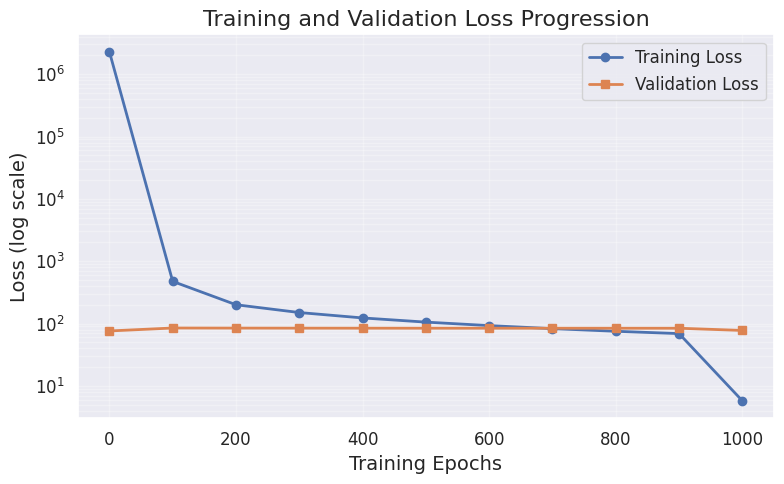

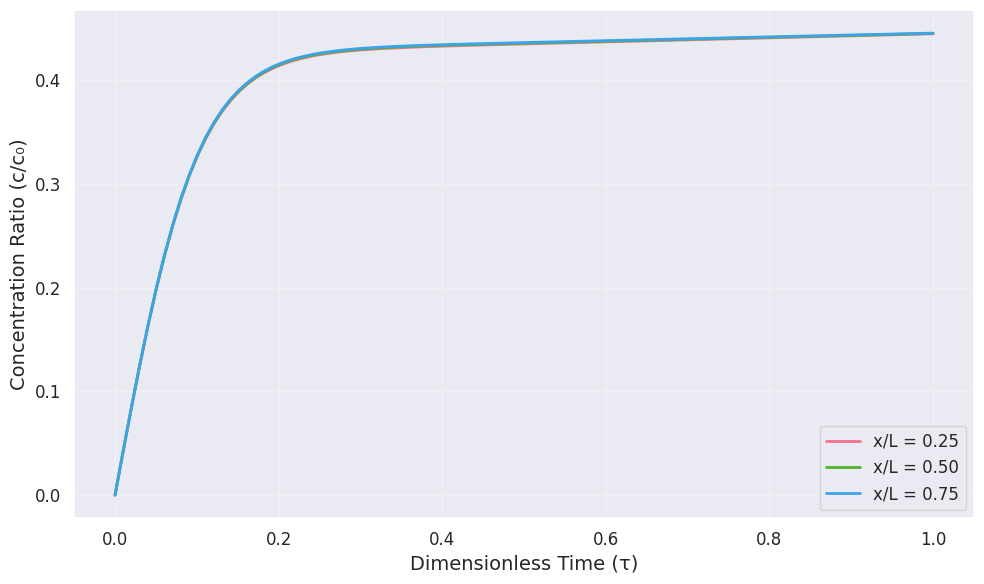

In [9]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        y = inputs
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)
        return self.hard_constraint(tau, y_pred, y_prev)

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        # Training data
        sampler = LatinHypercube(d=3)
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)
        X_ic_sample[:, 2] = 0.0

        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

        # Validation data
        self.N_val = 500
        val_sampler = LatinHypercube(d=3)
        X_val_sample = val_sampler.random(n=self.N_val)
        self.X_val = torch.tensor(X_val_sample, dtype=torch.float32, requires_grad=True)

        X_val_bc_sample = val_sampler.random(n=self.N_bc//2)
        self.X_val_bc = torch.tensor(X_val_bc_sample, dtype=torch.float32, requires_grad=True)

        X_val_ic_sample = val_sampler.random(n=self.N_ic//2)
        X_val_ic_sample[:, 2] = 0.0
        self.X_val_ic = torch.tensor(X_val_ic_sample, dtype=torch.float32, requires_grad=True)

        # Loss tracking
        self.train_losses = []
        self.val_losses = []

    def pde_residual(self, inputs):
        # Directly use inputs without redundant cloning
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Ensure gradient tracking for critical variables
        x.requires_grad_(True)
        tau.requires_grad_(True)
        y_prev.requires_grad_(True)

        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        # Compute first derivatives with error handling
        try:
            c_t = grad(c.sum(), tau, create_graph=True, retain_graph=True)[0]
            c_x = grad(c.sum(), x, create_graph=True, retain_graph=True)[0]
        except RuntimeError as e:
            print(f"Gradient computation failed: {e}")
            c_t = torch.zeros_like(tau)
            c_x = torch.zeros_like(x)

        # Compute second derivative safely
        try:
            c_xx = grad(c_x.sum(), x, create_graph=True, retain_graph=True)[0]
        except RuntimeError:
            c_xx = torch.zeros_like(x)

        # Physical equations remain unchanged
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual


    def boundary_loss(self, inputs):
        # Directly use inputs without redundant cloning
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Ensure gradient tracking for critical variables
        x.requires_grad_(True)
        tau.requires_grad_(True)
        y_prev.requires_grad_(True)

        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        # Compute spatial derivative with error handling
        try:
            c_x = grad(c.sum(), x, create_graph=True, retain_graph=True)[0]
        except RuntimeError as e:
            print(f"Gradient computation failed in boundary condition: {e}")
            c_x = torch.zeros_like(x)

        # Left boundary (Eq. 5)
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)

        # Right boundary (Eq. 6)
        bc_right = c_x

        return bc_left, bc_right

    def compute_val_loss(self):
        with torch.no_grad():
            loss_pde = torch.mean(self.pde_residual(self.X_val)**2)
            bc_left, bc_right = self.boundary_loss(self.X_val_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_val_ic)**2)
            return loss_pde + loss_bc + loss_ic

    def train(self):
        # Adam optimization
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            total_loss = (self.loss_weights['pde'] * loss_pde +
                         self.loss_weights['bc_left'] * loss_bc +
                         self.loss_weights['ic'] * loss_ic)

            total_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                val_loss = self.compute_val_loss().item()
                self.train_losses.append(total_loss.item())
                self.val_losses.append(val_loss)
                print(f"Epoch {epoch}: Train Loss {total_loss.item():.2e}, Val Loss {val_loss:.2e}")

        # L-BFGS optimization
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                     lr=1.0,
                                     max_iter=50000,
                                     line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)
            total_loss = loss_pde + loss_bc + loss_ic
            total_loss.backward()
            return total_loss

        optimizer.step(closure)

        # Record final losses
        self.train_losses.append(closure().item())
        self.val_losses.append(self.compute_val_loss().item())

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        sns.set_theme()
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def plot_training_curves(self):
        fig, ax = plt.subplots(figsize=(8, 5))
        epochs = np.arange(len(self.trainer.train_losses)) * 100

        ax.semilogy(epochs, self.trainer.train_losses,
                   label='Training Loss', marker='o')
        ax.semilogy(epochs, self.trainer.val_losses,
                   label='Validation Loss', marker='s')

        ax.set_xlabel('Training Epochs')
        ax.set_ylabel('Loss (log scale)')
        ax.set_title('Training and Validation Loss Progression')
        ax.legend()
        ax.grid(True, which='both', alpha=0.3)
        plt.tight_layout()

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        fig, ax = plt.subplots()
        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x, tau, y_prev], dim=1)
            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.legend()
        plt.tight_layout()

    def generate_all_plots(self):
        self.plot_training_curves()
        self.breakthrough_curves()
        plt.show()

if __name__ == "__main__":
    # Initialize and train
    trainer = PINNTrainer()
    trainer.train()

    # Generate plots
    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()


In [13]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))  # x, tau, y_prev
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Network computation
        y = inputs  # Start with the input tensor
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        # Apply hard constraint (Eq. 24)
        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        # Generate collocation points using LHS
        sampler = LatinHypercube(d=3)
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        # Generate sampling points
        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)

        # Initialize X_ic with y_prev=0
        X_ic_sample[:, 2] = 0.0

        # Split into train and validation sets (80-20 split)
        train_idx_f = int(0.8 * self.N_f)
        train_idx_bc = int(0.8 * self.N_bc)
        train_idx_ic = int(0.8 * self.N_ic)

        # Create training tensors with requires_grad=True
        self.X_f_train = torch.tensor(X_f_sample[:train_idx_f], dtype=torch.float32, requires_grad=True)
        self.X_bc_train = torch.tensor(X_bc_sample[:train_idx_bc], dtype=torch.float32, requires_grad=True)
        self.X_ic_train = torch.tensor(X_ic_sample[:train_idx_ic], dtype=torch.float32, requires_grad=True)

        # Create validation tensors with requires_grad=True
        self.X_f_val = torch.tensor(X_f_sample[train_idx_f:], dtype=torch.float32, requires_grad=True)
        self.X_bc_val = torch.tensor(X_bc_sample[train_idx_bc:], dtype=torch.float32, requires_grad=True)
        self.X_ic_val = torch.tensor(X_ic_sample[train_idx_ic:], dtype=torch.float32, requires_grad=True)

        # Lists to store training history
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

    def pde_residual(self, inputs):
        # Make sure input tensors require gradients (keeping original working pattern)
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradients with allow_unused=True (keeping original working pattern)
        c_t = grad(c.sum(), tau, create_graph=True, allow_unused=True)[0]
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]
        c_xx = grad(c_x.sum(), x, create_graph=True, allow_unused=True)[0]

        # Calculate q derivative (Eq. 2)
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        # Dimensionless PDE residual (Eq. 15)
        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual

    def boundary_loss(self, inputs):
        # Make sure input tensors require gradients (keeping original working pattern)
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradient (keeping original working pattern)
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]

        # Left boundary (Eq. 5)
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)

        # Right boundary (Eq. 6)
        bc_right = c_x
        return bc_left, bc_right

    def calculate_loss(self, X_f, X_bc, X_ic):
        """Calculate total loss for given data."""
        loss_pde = torch.mean(self.pde_residual(X_f)**2)
        bc_left, bc_right = self.boundary_loss(X_bc)
        loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
        loss_ic = torch.mean(self.pinn(X_ic)**2)

        total_loss = (self.loss_weights['pde'] * loss_pde +
                     self.loss_weights['bc_left'] * loss_bc +
                     self.loss_weights['ic'] * loss_ic)
        return total_loss

    def train(self):
        # Adam optimization phase
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)

        for epoch in range(1000):
            optimizer.zero_grad()

            # Calculate training loss
            train_loss = self.calculate_loss(self.X_f_train, self.X_bc_train, self.X_ic_train)

            # Calculate validation loss
            with torch.no_grad():
                val_loss = self.calculate_loss(self.X_f_val, self.X_bc_val, self.X_ic_val)

            # Store losses
            self.train_losses.append(train_loss.item())
            self.val_losses.append(val_loss.item())
            self.epochs.append(epoch)

            # Backward pass and optimization
            train_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4e}, Val Loss = {val_loss.item():.4e}")

        # L-BFGS-B fine-tuning
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0,
                                    max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss = self.calculate_loss(self.X_f_train, self.X_bc_train, self.X_ic_train)
            loss.backward()
            return loss

        optimizer.step(closure)

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        """Set up default plotting style."""
        # Use seaborn's default style
        sns.set_theme()

        # Additional customization
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        """Plot breakthrough curves at different bed positions."""
        fig, ax = plt.subplots()

        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Bed Positions')
        ax.legend()
        plt.tight_layout()

    def concentration_profiles(self, t_values=[0.2, 0.4, 0.6, 0.8], x_points=100):
        """Plot concentration profiles along the bed at different times."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, x_points)
        colors = sns.color_palette("husl", len(t_values))

        for t_val, color in zip(t_values, colors):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((x_points,), t_val, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(x, c_ratio, label=f'τ = {t_val:.2f}', color=color)

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Concentration Profiles at Different Times')
        ax.legend()
        plt.tight_layout()

    def spatiotemporal_heatmap(self, nx=50, nt=50):
        """Generate a 2D heatmap of concentration over space and time."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, nx)
        t = np.linspace(0, 1, nt)
        X, T = np.meshgrid(x, t)

        c_matrix = np.zeros((nt, nx))

        for i in range(nt):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((nx,), t[i], dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_matrix[i, :] = c.numpy().flatten() / self.pinn.c0.item()

        im = ax.pcolormesh(X, T, c_matrix, shading='auto', cmap='viridis')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax, label='c/c₀')

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Dimensionless Time (τ)')
        ax.set_title('Spatiotemporal Evolution of Concentration')
        plt.tight_layout()

    def parameter_sensitivity(self, param_ranges={
        'Pe': np.linspace(50, 200, 5),
        'Sh': np.linspace(5, 20, 5)
    }):
        """Analyze sensitivity to key parameters."""
        fig, axes = plt.subplots(1, len(param_ranges), figsize=(15, 5))

        x_pos = 0.5  # Middle of the bed
        t = np.linspace(0, 1, 100)

        for i, (param, values) in enumerate(param_ranges.items()):
            ax = axes[i]
            original_value = getattr(self.pinn, param).item()
            colors = sns.color_palette("husl", len(values))

            for value, color in zip(values, colors):
                setattr(self.pinn, param, torch.tensor(value, dtype=torch.float32))

                x = torch.full((100,), x_pos, dtype=torch.float32)
                tau = torch.tensor(t, dtype=torch.float32)
                y_prev = torch.zeros_like(tau)

                inputs = torch.stack([x, tau, y_prev], dim=1)

                with torch.no_grad():
                    c = self.pinn(inputs)

                c_ratio = c.numpy() / self.pinn.c0.item()
                ax.plot(t, c_ratio, label=f'{param}={value:.1f}', color=color)

            # Reset parameter to original value
            setattr(self.pinn, param, torch.tensor(original_value, dtype=torch.float32))

            ax.set_xlabel('Dimensionless Time (τ)')
            ax.set_ylabel('Concentration Ratio (c/c₀)')
            ax.set_title(f'Sensitivity to {param}')
            ax.legend()

        plt.tight_layout()

    def error_analysis(self):
        """Analyze PDE residuals and boundary condition errors."""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig)

        # PDE residuals
        ax1 = fig.add_subplot(gs[0, 0])
        residuals = self.trainer.pde_residual(self.trainer.X_f)
        sns.histplot(residuals.detach().numpy(), bins=50, ax=ax1)
        ax1.set_xlabel('PDE Residual')
        ax1.set_ylabel('Count')
        ax1.set_title('Distribution of PDE Residuals')

        # Boundary condition errors
        ax2 = fig.add_subplot(gs[0, 1])
        bc_left, bc_right = self.trainer.boundary_loss(self.trainer.X_bc)
        sns.histplot(bc_left.detach().numpy(), bins=50, alpha=0.5, label='Left BC', ax=ax2)
        sns.histplot(bc_right.detach().numpy(), bins=50, alpha=0.5, label='Right BC', ax=ax2)
        ax2.set_xlabel('BC Error')
        ax2.set_ylabel('Count')
        ax2.set_title('Distribution of Boundary Condition Errors')
        ax2.legend()

        # Spatial distribution of errors
        ax3 = fig.add_subplot(gs[1, :])
        x = self.trainer.X_f[:, 0].detach().numpy()
        errors = torch.abs(residuals).detach().numpy()

        # Option 1: Using plt.scatter directly
        ax3.scatter(x, errors, alpha=0.5, s=10, c='blue')

        ax3.set_xlabel('Dimensionless Position (x/L)')
        ax3.set_ylabel('Absolute PDE Residual')
        ax3.set_title('Spatial Distribution of PDE Residuals')
        ax3.set_yscale('log')

        plt.tight_layout()

    def plot_loss_history(self):
        """Plot training and validation loss history."""
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.trainer.epochs, self.trainer.train_losses, label='Training Loss', color='blue')
        plt.semilogy(self.trainer.epochs, self.trainer.val_losses, label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.title('Training and Validation Loss History')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

    def generate_all_plots(self):
        """Generate all plots in sequence."""
        self.breakthrough_curves()
        plt.figure()
        self.concentration_profiles()
        plt.figure()
        self.spatiotemporal_heatmap()
        plt.figure()
        self.parameter_sensitivity()
        plt.figure()
        self.error_analysis()
        plt.figure()
        self.plot_loss_history()
        plt.show()

# Modified main execution
if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    # Create plotter and generate all plots
    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [17]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        y = inputs
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        # Training data
        sampler = LatinHypercube(d=3)
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)

        # Convert to tensors
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

        # Validation data (20% of training sizes)
        val_sampler = LatinHypercube(d=3)

        # Create NUMPY arrays first
        X_val_f_sample = val_sampler.random(n=300)
        X_val_bc_sample = val_sampler.random(n=110)
        X_val_ic_sample = val_sampler.random(n=140)
        X_val_ic_sample[:, 2] = 0.0  # Modify numpy array

        # Now convert to tensors
        self.X_val_f = torch.tensor(X_val_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_val_bc = torch.tensor(X_val_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_val_ic = torch.tensor(X_val_ic_sample, dtype=torch.float32, requires_grad=True)

        # Loss tracking
        self.train_losses = []
        self.val_losses = []

    def calculate_total_loss(self, X_f, X_bc, X_ic):
        loss_pde = torch.mean(self.pde_residual(X_f)**2)
        bc_left, bc_right = self.boundary_loss(X_bc)
        loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
        loss_ic = torch.mean(self.pinn(X_ic)**2)
        return loss_pde + loss_bc + loss_ic

    def pde_residual(self, inputs):
        # Clone and explicitly enable gradients for all input components
        x = inputs[:, 0:1].clone().detach().requires_grad_(True)
        tau = inputs[:, 1:2].clone().detach().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().detach().requires_grad_(True)

        # Create network input with gradient tracking
        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        # Compute gradients with retained computation graph
        c_t = grad(c.sum(), tau, create_graph=True, retain_graph=True, allow_unused=False)[0]
        c_x = grad(c.sum(), x, create_graph=True, retain_graph=True, allow_unused=False)[0]
        c_xx = grad(c_x.sum(), x, create_graph=True, retain_graph=True, allow_unused=False)[0]

        # Calculate residual using original parameters
        x_physical = x * self.pinn.L
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual


    def boundary_loss(self, inputs):
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        network_input = torch.cat([x, tau, y_prev], dim=1)
        c = self.pinn(network_input)

        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)
        bc_right = c_x
        return bc_left, bc_right

    def train(self):
        # Phase 1: Adam optimization
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            loss = self.calculate_total_loss(self.X_f, self.X_bc, self.X_ic)
            loss.backward()
            optimizer.step()

            # Validation
            with torch.no_grad():
                train_loss = loss.item()
                val_loss = self.calculate_total_loss(self.X_val_f, self.X_val_bc, self.X_val_ic).item()

                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4e}, Val Loss = {val_loss:.4e}")

        # Phase 2: L-BFGS fine-tuning
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0,
                                    max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss = self.calculate_total_loss(self.X_f, self.X_bc, self.X_ic)
            loss.backward()
            return loss

        optimizer.step(closure)

        # Final validation after L-BFGS
        with torch.no_grad():
            final_val_loss = self.calculate_total_loss(self.X_val_f, self.X_val_bc, self.X_val_ic).item()
            self.val_losses.append(final_val_loss)
            self.train_losses.append(self.calculate_total_loss(self.X_f, self.X_bc, self.X_ic).item())

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        sns.set_theme()
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def training_curve(self):
        fig, ax = plt.subplots()
        ax.semilogy(self.trainer.train_losses, label='Training Loss')
        ax.semilogy(self.trainer.val_losses, label='Validation Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_title('Training and Validation Loss Curves')
        plt.tight_layout()

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        fig, ax = plt.subplots()
        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)
            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Bed Positions')
        ax.legend()
        plt.tight_layout()

    def generate_all_plots(self):
        self.training_curve()
        plt.figure()
        self.breakthrough_curves()
        plt.show()

if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Epoch 0: Total Loss = 1.3021e+07


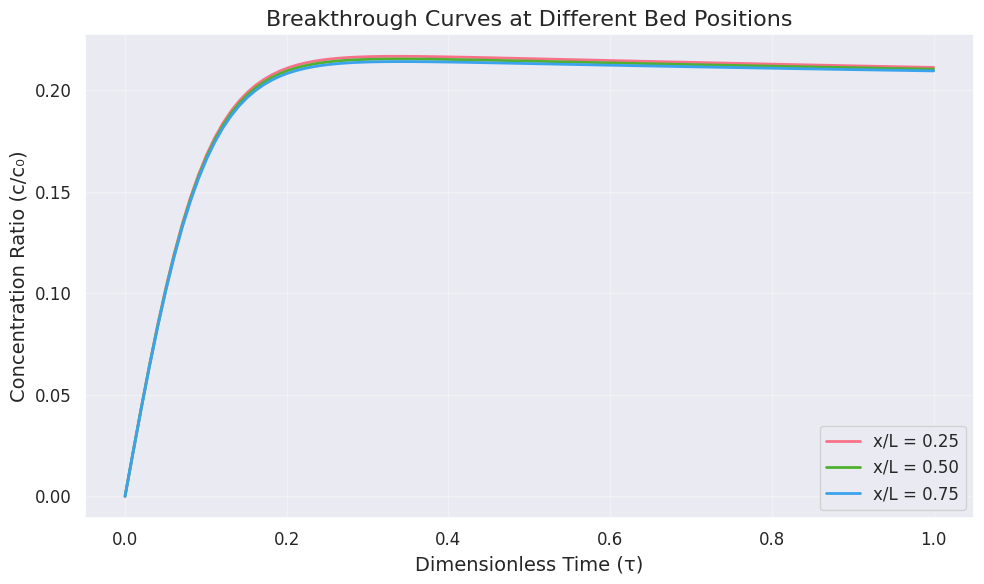

<Figure size 1000x600 with 0 Axes>

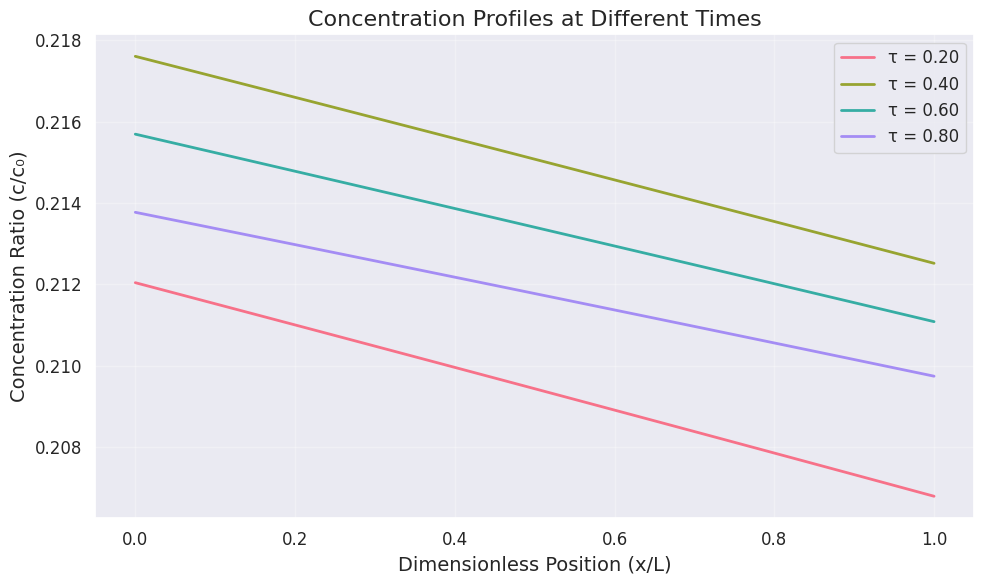

<Figure size 1000x600 with 0 Axes>

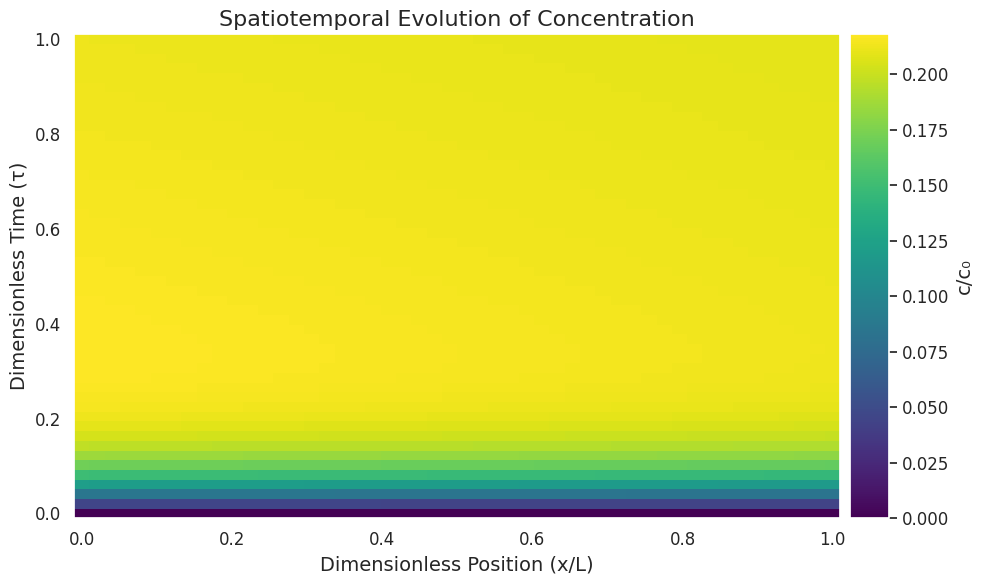

<Figure size 1000x600 with 0 Axes>

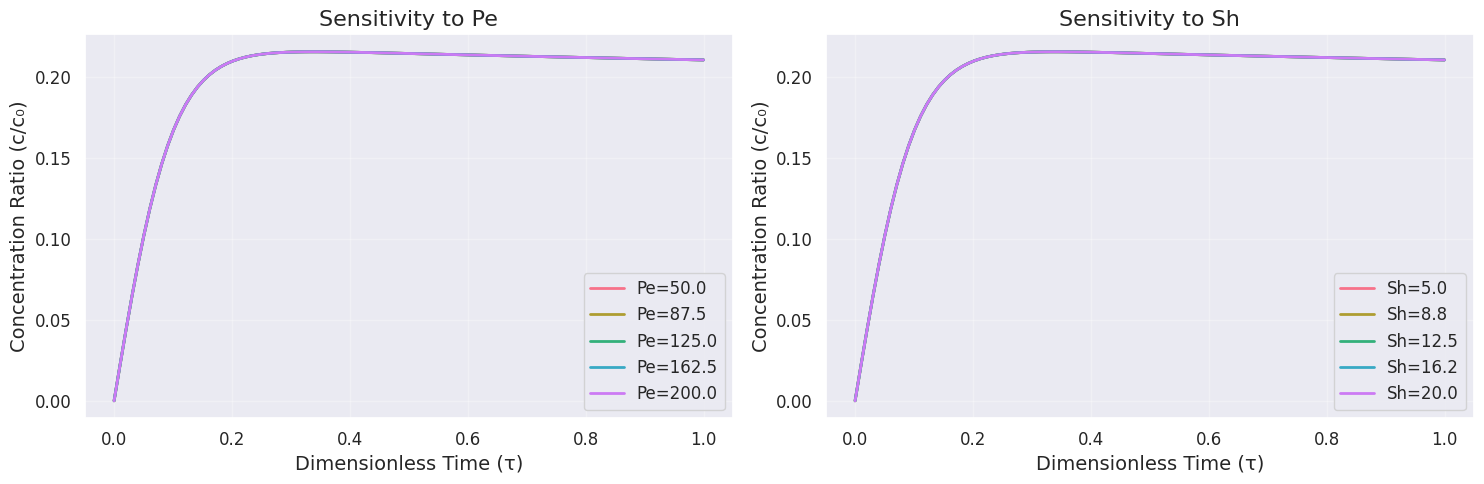

<Figure size 1000x600 with 0 Axes>

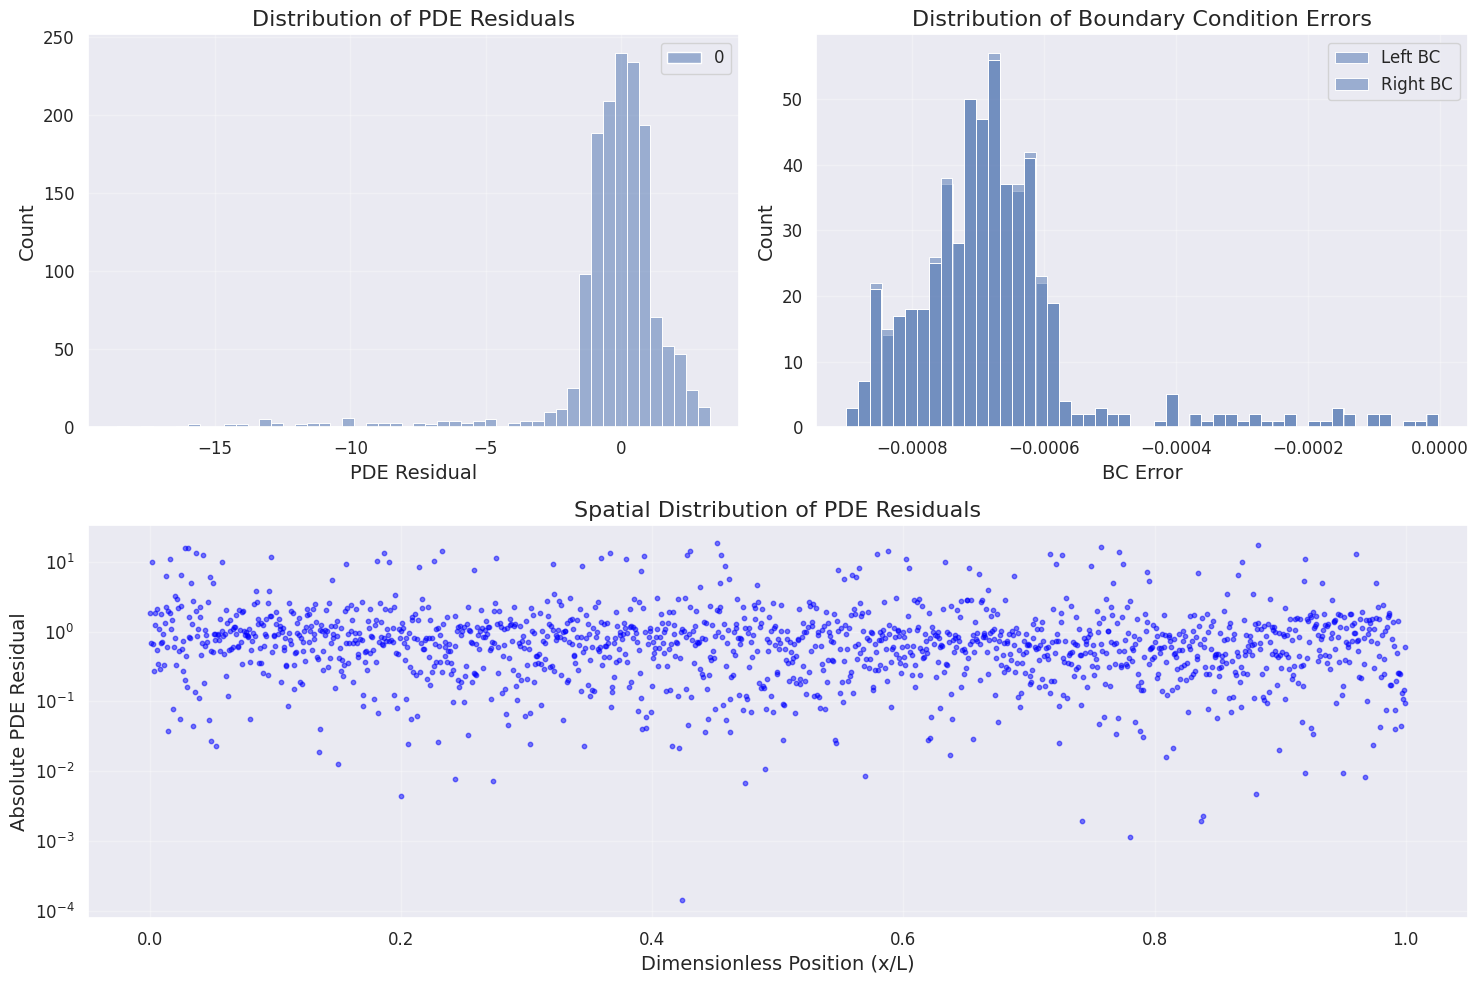

In [ ]:
import torch
import numpy as np
from torch.autograd import grad
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

class FixedBedPINN(torch.nn.Module):
    def __init__(self, num_layers=5, hidden_units=50):
        super().__init__()
        torch.set_default_dtype(torch.float32)

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(3, hidden_units))  # x, tau, y_prev
        for _ in range(num_layers-2):
            self.layers.append(torch.nn.Linear(hidden_units, hidden_units))
        self.layers.append(torch.nn.Linear(hidden_units, 1))
        self.activation = torch.nn.Tanh()

        # Fixed parameters from Table II
        self.epsilon = torch.tensor(0.35, dtype=torch.float32)
        self.rho_L = torch.tensor(1000.0, dtype=torch.float32)
        self.L = torch.tensor(0.12, dtype=torch.float32)
        self.d_p = torch.tensor(0.0007, dtype=torch.float32)
        self.mu_m = torch.tensor(89.15e-6, dtype=torch.float32)
        self.D_Na = torch.tensor(1.34e-9, dtype=torch.float32)
        self.D_SO4 = torch.tensor(1.06e-9, dtype=torch.float32)
        self.c0 = torch.tensor(0.17, dtype=torch.float32)
        self.c_eq = torch.tensor(0.4278, dtype=torch.float32)
        self.Q = torch.tensor(8.50e-9, dtype=torch.float32)
        self.S = torch.tensor(0.000531, dtype=torch.float32)

        # Derived dimensionless numbers
        self.Pe = self.calculate_peclet()
        self.Sh = self.calculate_sherwood()

    def calculate_peclet(self):
        V_s = self.Q / self.S
        u0 = V_s / self.epsilon
        D_m = self.calculate_diffusivity()
        D_L = u0 * self.d_p * (20/self.epsilon) * (D_m/(u0*self.d_p)) + 0.5
        return (u0 * self.L**2) / D_L

    def calculate_sherwood(self):
        Re = (self.rho_L * (self.Q/self.S) * self.d_p) / self.mu_m
        Sc = self.mu_m / (self.rho_L * self.calculate_diffusivity())
        return 2 + 1.1 * Re**0.6 * Sc**(1/3)

    def calculate_diffusivity(self):
        return (2 * self.D_Na * self.D_SO4) / (self.D_Na + self.D_SO4)

    def hard_constraint(self, t_nn, y_pred, y_prev):
        a = torch.tensor(10.0, dtype=torch.float32)
        t_alpha = (torch.exp(a*t_nn) - torch.exp(-a*t_nn)) / (torch.exp(a*t_nn) + torch.exp(-a*t_nn))
        b = torch.tensor(0.5, dtype=torch.float32)
        return t_alpha * ((1 - b) * y_pred + b * y_prev)

    def forward(self, inputs):
        x = inputs[:, 0:1]
        tau = inputs[:, 1:2]
        y_prev = inputs[:, 2:3]

        # Network computation
        y = inputs  # Start with the input tensor
        for layer in self.layers[:-1]:
            y = self.activation(layer(y))
        y_pred = self.layers[-1](y)

        # Apply hard constraint (Eq. 24)
        y_constrained = self.hard_constraint(tau, y_pred, y_prev)
        return y_constrained

class PINNTrainer:
    def __init__(self):
        self.pinn = FixedBedPINN()
        self.loss_weights = {
            'pde': torch.tensor(1.0, dtype=torch.float32),
            'bc_left': torch.tensor(1.0, dtype=torch.float32),
            'bc_right': torch.tensor(1.0, dtype=torch.float32),
            'ic': torch.tensor(1.0, dtype=torch.float32)
        }

        # Generate collocation points using LHS
        sampler = LatinHypercube(d=3)  # Changed to 3D sampling for x, tau, and y_prev
        self.N_f = 1500
        self.N_bc = 550
        self.N_ic = 700

        # Generate sampling points with correct dimensions
        X_f_sample = sampler.random(n=self.N_f)
        X_bc_sample = sampler.random(n=self.N_bc)
        X_ic_sample = sampler.random(n=self.N_ic)

        # Convert to tensors with proper shapes (batch_size x 3)
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

        # Initialize X_ic with y_prev=0 before creating tensor
        X_ic_sample[:, 2] = 0.0

        # Convert to tensors with proper shapes (batch_size x 3)
        self.X_f = torch.tensor(X_f_sample, dtype=torch.float32, requires_grad=True)
        self.X_bc = torch.tensor(X_bc_sample, dtype=torch.float32, requires_grad=True)
        self.X_ic = torch.tensor(X_ic_sample, dtype=torch.float32, requires_grad=True)

    def pde_residual(self, inputs):
        # Make sure input tensors require gradients
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradients with allow_unused=True
        c_t = grad(c.sum(), tau, create_graph=True, allow_unused=True)[0]
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]
        c_xx = grad(c_x.sum(), x, create_graph=True, allow_unused=True)[0]

        # Scale x back to physical coordinates after gradient computation
        x_physical = x * self.pinn.L

        # Calculate q derivative (Eq. 2)
        k_e = (self.pinn.Sh * self.pinn.calculate_diffusivity()) / self.pinn.d_p
        q_t = (3 * k_e / self.pinn.d_p) * (c - self.pinn.c_eq)

        # Dimensionless PDE residual (Eq. 15)
        residual = c_t - (1/self.pinn.Pe)*c_xx + c_x + ((1-self.pinn.epsilon)/self.pinn.epsilon)*self.pinn.rho_L*q_t
        return residual

    def boundary_loss(self, inputs):
        # Make sure input tensors require gradients
        x = inputs[:, 0:1].clone().requires_grad_(True)
        tau = inputs[:, 1:2].clone().requires_grad_(True)
        y_prev = inputs[:, 2:3].clone().requires_grad_(True)

        # Create new input tensor for network
        network_input = torch.cat([x, tau, y_prev], dim=1)

        # Get network output
        c = self.pinn(network_input)

        # Calculate gradient with allow_unused=True
        c_x = grad(c.sum(), x, create_graph=True, allow_unused=True)[0]

        # Left boundary (Eq. 5)
        bc_left = c_x - self.pinn.Pe * (c - self.pinn.c0)

        # Right boundary (Eq. 6)
        bc_right = c_x
        return bc_left, bc_right

    def train(self):
        # Adam optimization phase
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=1e-3)
        for epoch in range(1000):
            optimizer.zero_grad()

            # Compute all loss components
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)

            total_loss = (self.loss_weights['pde'] * loss_pde +
                         self.loss_weights['bc_left'] * loss_bc +
                         self.loss_weights['ic'] * loss_ic)

            total_loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4e}")

        # L-BFGS-B fine-tuning
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    lr=1.0,
                                    max_iter=50000,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss_pde = torch.mean(self.pde_residual(self.X_f)**2)
            bc_left, bc_right = self.boundary_loss(self.X_bc)
            loss_bc = torch.mean(bc_left**2) + torch.mean(bc_right**2)
            loss_ic = torch.mean(self.pinn(self.X_ic)**2)
            total_loss = loss_pde + loss_bc + loss_ic
            total_loss.backward()
            return total_loss

        optimizer.step(closure)

class PINNPlotter:
    def __init__(self, trainer):
        self.trainer = trainer
        self.pinn = trainer.pinn
        self.setup_default_plot_style()

    def setup_default_plot_style(self):
        """Set up default plotting style."""
        # Use seaborn's default style
        sns.set_theme()

        # Additional customization
        plt.rcParams.update({
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'legend.fontsize': 12,
            'figure.figsize': (10, 6),
            'lines.linewidth': 2,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def breakthrough_curves(self, x_positions=[0.25, 0.5, 0.75], t_points=100):
        """Plot breakthrough curves at different bed positions."""
        fig, ax = plt.subplots()

        t = np.linspace(0, 1, t_points)
        colors = sns.color_palette("husl", len(x_positions))

        for x_pos, color in zip(x_positions, colors):
            x = torch.full((t_points,), x_pos, dtype=torch.float32)
            tau = torch.tensor(t, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(t, c_ratio, label=f'x/L = {x_pos:.2f}', color=color)

        ax.set_xlabel('Dimensionless Time (τ)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Breakthrough Curves at Different Bed Positions')
        ax.legend()
        plt.tight_layout()

    def concentration_profiles(self, t_values=[0.2, 0.4, 0.6, 0.8], x_points=100):
        """Plot concentration profiles along the bed at different times."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, x_points)
        colors = sns.color_palette("husl", len(t_values))

        for t_val, color in zip(t_values, colors):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((x_points,), t_val, dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_ratio = c.numpy() / self.pinn.c0.item()
            ax.plot(x, c_ratio, label=f'τ = {t_val:.2f}', color=color)

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Concentration Ratio (c/c₀)')
        ax.set_title('Concentration Profiles at Different Times')
        ax.legend()
        plt.tight_layout()

    def spatiotemporal_heatmap(self, nx=50, nt=50):
        """Generate a 2D heatmap of concentration over space and time."""
        fig, ax = plt.subplots()

        x = np.linspace(0, 1, nx)
        t = np.linspace(0, 1, nt)
        X, T = np.meshgrid(x, t)

        c_matrix = np.zeros((nt, nx))

        for i in range(nt):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            tau = torch.full((nx,), t[i], dtype=torch.float32)
            y_prev = torch.zeros_like(tau)

            inputs = torch.stack([x_tensor, tau, y_prev], dim=1)

            with torch.no_grad():
                c = self.pinn(inputs)

            c_matrix[i, :] = c.numpy().flatten() / self.pinn.c0.item()

        im = ax.pcolormesh(X, T, c_matrix, shading='auto', cmap='viridis')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax, label='c/c₀')

        ax.set_xlabel('Dimensionless Position (x/L)')
        ax.set_ylabel('Dimensionless Time (τ)')
        ax.set_title('Spatiotemporal Evolution of Concentration')
        plt.tight_layout()

    def parameter_sensitivity(self, param_ranges={
        'Pe': np.linspace(50, 200, 5),
        'Sh': np.linspace(5, 20, 5)
    }):
        """Analyze sensitivity to key parameters."""
        fig, axes = plt.subplots(1, len(param_ranges), figsize=(15, 5))

        x_pos = 0.5  # Middle of the bed
        t = np.linspace(0, 1, 100)

        for i, (param, values) in enumerate(param_ranges.items()):
            ax = axes[i]
            original_value = getattr(self.pinn, param).item()
            colors = sns.color_palette("husl", len(values))

            for value, color in zip(values, colors):
                setattr(self.pinn, param, torch.tensor(value, dtype=torch.float32))

                x = torch.full((100,), x_pos, dtype=torch.float32)
                tau = torch.tensor(t, dtype=torch.float32)
                y_prev = torch.zeros_like(tau)

                inputs = torch.stack([x, tau, y_prev], dim=1)

                with torch.no_grad():
                    c = self.pinn(inputs)

                c_ratio = c.numpy() / self.pinn.c0.item()
                ax.plot(t, c_ratio, label=f'{param}={value:.1f}', color=color)

            # Reset parameter to original value
            setattr(self.pinn, param, torch.tensor(original_value, dtype=torch.float32))

            ax.set_xlabel('Dimensionless Time (τ)')
            ax.set_ylabel('Concentration Ratio (c/c₀)')
            ax.set_title(f'Sensitivity to {param}')
            ax.legend()

        plt.tight_layout()

    def error_analysis(self):
        """Analyze PDE residuals and boundary condition errors."""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig)

        # PDE residuals
        ax1 = fig.add_subplot(gs[0, 0])
        residuals = self.trainer.pde_residual(self.trainer.X_f)
        sns.histplot(residuals.detach().numpy(), bins=50, ax=ax1)
        ax1.set_xlabel('PDE Residual')
        ax1.set_ylabel('Count')
        ax1.set_title('Distribution of PDE Residuals')

        # Boundary condition errors
        ax2 = fig.add_subplot(gs[0, 1])
        bc_left, bc_right = self.trainer.boundary_loss(self.trainer.X_bc)
        sns.histplot(bc_left.detach().numpy(), bins=50, alpha=0.5, label='Left BC', ax=ax2)
        sns.histplot(bc_right.detach().numpy(), bins=50, alpha=0.5, label='Right BC', ax=ax2)
        ax2.set_xlabel('BC Error')
        ax2.set_ylabel('Count')
        ax2.set_title('Distribution of Boundary Condition Errors')
        ax2.legend()

        # Spatial distribution of errors
        ax3 = fig.add_subplot(gs[1, :])
        x = self.trainer.X_f[:, 0].detach().numpy()
        errors = torch.abs(residuals).detach().numpy()

        # Option 1: Using plt.scatter directly
        ax3.scatter(x, errors, alpha=0.5, s=10, c='blue')

        ax3.set_xlabel('Dimensionless Position (x/L)')
        ax3.set_ylabel('Absolute PDE Residual')
        ax3.set_title('Spatial Distribution of PDE Residuals')
        ax3.set_yscale('log')

        plt.tight_layout()

    def generate_all_plots(self):
        """Generate all plots in sequence."""
        self.breakthrough_curves()
        plt.figure()
        self.concentration_profiles()
        plt.figure()
        self.spatiotemporal_heatmap()
        plt.figure()
        self.parameter_sensitivity()
        plt.figure()
        self.error_analysis()
        plt.show()

# Modified main execution
if __name__ == "__main__":
    trainer = PINNTrainer()
    trainer.train()

    # Create plotter and generate all plots
    plotter = PINNPlotter(trainer)
    plotter.generate_all_plots()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

#New Stuff

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# ======================
# Custom Activation (replacing Sinh with Tanh)
# ======================
class Tanh(torch.nn.Module):
    def forward(self, x):
        return torch.tanh(x)

# ======================
# Enhanced PINN Architecture
# ======================
class EnhancedHgPINN(torch.nn.Module):
    def __init__(self, num_velocities=9, hidden_size=64):
        super().__init__()
        self.Q = num_velocities

        # Subnetworks
        self.NN_eq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )

        self.NN_neq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, self.Q)
        )

        self.NN_Gamma = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )

        # D2Q9 lattice parameters
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.xi = torch.tensor([
            [0,0], [1,0], [0,1], [-1,0], [0,-1],
            [1,1], [-1,1], [-1,-1], [1,-1]
        ], dtype=torch.float32)

    def forward(self, x):
        """
        x is shape [batch_size, 2]: columns = [x, t].
        """
        C = self.NN_eq(x)      # shape [batch_size, 1]
        Gamma = self.NN_Gamma(x)  # shape [batch_size, 1]
        f_neq = self.NN_neq(x) # shape [batch_size, Q]
        return C, Gamma, f_neq

# ======================
# Physics Constraints
# ======================
class PhysicsConstraints:
    def __init__(self, pinn, params):
        self.pinn = pinn
        self.tau = params['tau']
        self.k_a = params['k_a']
        self.k_d = params['k_d']
        self.Gamma_inf = params['Gamma_inf']
        self.C_in = params['C_in']
        self.L = params['L']

    def compute_residuals(self, x, t):
        """
        x, t: [N,1] Tensors with requires_grad=True.
        Returns:
            residual: [N, Q]
            Gamma_res: [N, 1]
            C, Gamma: [N, 1]
            f_neq: [N, Q]
        """
        inputs = torch.cat([x, t], dim=1)
        C, Gamma, f_neq = self.pinn(inputs)

        # Derivatives of C, Gamma w.r.t. x, t
        dC_dx = grad(C, x, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dC_dt = grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dGamma_dt = grad(Gamma, t, grad_outputs=torch.ones_like(Gamma), create_graph=True)[0]

        # Because we are doing 1D (flow along x), only use xi_x:
        u = self.pinn.xi[:, 0].reshape(1, -1)  # shape [1, Q]

        # For multi-output f_neq, compute partial derivatives channel-by-channel
        N = x.shape[0]
        df_neq_dx_list = []
        df_neq_dt_list = []

        # Loop over velocity distributions
        for i in range(self.pinn.Q):
            # partial w.r.t. x
            df_neq_dx_i = grad(
                f_neq[:, i].sum(),  # sum so it's scalar
                x,
                create_graph=True
            )[0]  # shape [N,1]
            df_neq_dx_list.append(df_neq_dx_i)

            # partial w.r.t. t
            df_neq_dt_i = grad(
                f_neq[:, i].sum(),
                t,
                create_graph=True
            )[0]
            df_neq_dt_list.append(df_neq_dt_i)

        # Concatenate to shape [N, Q]
        df_neq_dx = torch.cat(df_neq_dx_list, dim=1)
        df_neq_dt = torch.cat(df_neq_dt_list, dim=1)

        # Source term S: shape [N, 9]
        # (k_a*C*(Gamma_inf - Gamma) - k_d*Gamma) => shape [N,1], multiply by w => [9], broadcast => [N,9]
        S_raw = self.k_a*C*(self.Gamma_inf - Gamma) - self.k_d*Gamma
        S = self.pinn.w * S_raw  # shape [9], broadcast => [N,9]


        residual = df_neq_dt + u * df_neq_dx + (1/self.tau)*f_neq + S

        # Adsorption PDE: dGamma/dt = (k_a*C*(Gamma_inf - Gamma) - k_d*Gamma)
        Gamma_res = dGamma_dt - S_raw  # shape [N,1]

        return residual, Gamma_res, C, Gamma, f_neq

# ======================
# Hybrid Optimizer
# ======================
class HybridOptimizer:
    def __init__(self, pinn, physics, params):
        self.pinn = pinn
        self.physics = physics
        self.params = params

    def adam_phase(self):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for epoch_i in range(self.params['adam_epochs']):
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            if torch.isnan(loss):
                print(f"NaN encountered at epoch {epoch_i}. Stopping.")
                break
            loss.backward()
            optimizer.step()

            if epoch_i % 200 == 0:
                print(f"[Adam Epoch {epoch_i}] loss = {loss.item():.6f}")
                self.debug_test_predictions()

    def lbfgs_phase(self):
        optimizer = torch.optim.LBFGS(
            self.pinn.parameters(),
            max_iter=self.params['lbfgs_iter'],
            history_size=50,
            line_search_fn='strong_wolfe'
        )

        def closure():
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            return loss

        optimizer.step(closure)

    def compute_total_loss(self):
        # Collocation points
        x_col = torch.rand((1000,1), requires_grad=True) * self.params['L']
        t_col = torch.rand((1000,1), requires_grad=True) * self.params['T']

        # Boundary points
        x_inlet = torch.zeros((200,1), requires_grad=True)
        t_inlet = torch.rand((200,1), requires_grad=True) * self.params['T']
        x_outlet = torch.ones((200,1), requires_grad=True) * self.params['L']
        t_outlet = torch.rand((200,1), requires_grad=True) * self.params['T']

        # Initial conditions
        x_ic = torch.rand((500,1), requires_grad=True) * self.params['L']
        t_ic = torch.zeros((500,1), requires_grad=True)

        # Synthetic data points
        x_data = torch.rand((300,1)) * self.params['L']
        t_data = torch.rand((300,1)) * self.params['T']
        C_data = torch.exp(-x_data**2) * torch.sin(2*np.pi*t_data/self.params['T']).squeeze()

        # PDE residuals
        residual, Gamma_res, C_col, Gamma_col, f_neq_col = self.physics.compute_residuals(x_col, t_col)

        inputs_data = torch.cat([x_data, t_data], dim=1)
        C_data_pred, Gamma_data_pred, _ = self.pinn(inputs_data)
        C_data_pred = C_data_pred.squeeze()

        # Loss components
        L_eq = torch.mean(residual**2)
        L_Gamma = torch.mean(Gamma_res**2)
        L_ic = self.initial_condition_loss(x_ic, t_ic)
        L_bc = self.boundary_loss(x_inlet, t_inlet, x_outlet, t_outlet)
        L_data = torch.mean((C_data_pred - C_data)**2)

        return 0.3*L_eq + 0.2*L_Gamma + 0.2*L_ic + 0.2*L_bc + 0.1*L_data

    def initial_condition_loss(self, x, t):
        # Suppose the initial condition is C=0, Gamma=0, f_neq=0
        inputs = torch.cat([x, t], dim=1)
        C, Gamma, f_neq = self.pinn(inputs)
        return torch.mean(C**2) + torch.mean(Gamma**2) + torch.mean(f_neq**2)

    def boundary_loss(self, x_inlet, t_inlet, x_outlet, t_outlet):
        # Inlet boundary (Dirichlet)
        inputs_in = torch.cat([x_inlet, t_inlet], dim=1)
        C_in, _, _ = self.pinn(inputs_in)
        L_inlet = torch.mean((C_in - self.params['C_in'])**2)

        # Outlet boundary (Neumann: dC/dx=0)
        inputs_out = torch.cat([x_outlet, t_outlet], dim=1)
        C_out, _, _ = self.pinn(inputs_out)
        dC_dx = grad(C_out, x_outlet,
                     grad_outputs=torch.ones_like(C_out),
                     create_graph=True)[0]
        L_outlet = torch.mean(dC_dx**2)

        return 0.7*L_inlet + 0.3*L_outlet

    def debug_test_predictions(self):
        # Quick test at x=0, x=L/2, x=L, with t=0, t=T/2, t=T
        x_test = torch.tensor([[0.0],[self.params['L']/2],[self.params['L']]])
        t_test = torch.tensor([[0.0],[self.params['T']/2],[self.params['T']]])
        inputs_test = torch.cat([x_test, t_test], dim=1)
        C_test, Gamma_test, _ = self.pinn(inputs_test)
        print("  x_test:", x_test.view(-1).tolist())
        print("  t_test:", t_test.view(-1).tolist())
        print("  C_test:", C_test.view(-1).tolist())
        print("  Gamma_test:", Gamma_test.view(-1).tolist())

# ======================
# Simulation Parameters
# ======================
sim_params = {
    'tau': 0.6,
    'k_a': 0.15,
    'k_d': 0.02,
    'Gamma_inf': 1.8,
    'C_in': 1.0,
    'L': 10.0,
    'T': 5.0,
    'adam_epochs': 2000,
    'lbfgs_iter': 500
}

# ======================
# Main Simulation
# ======================
def main():
    pinn = EnhancedHgPINN(num_velocities=9, hidden_size=64)
    physics = PhysicsConstraints(pinn, sim_params)
    optimizer = HybridOptimizer(pinn, physics, sim_params)

    # Print parameter stats more carefully
    print("===> Initial Parameter Stats (biases just 1 element => std=NaN is normal):")
    for name, param in pinn.named_parameters():
        v = param.data
        if v.numel() == 1:
            print(f"{name}: single_value={v.item():.5f}")
        else:
            print(f"{name}: mean={v.mean():.5f}, std={v.std():.5f}")
    print()

    print("Starting Adam phase...")
    optimizer.adam_phase()

    print("\nStarting L-BFGS phase...")
    optimizer.lbfgs_phase()

    print("\n===> Final Parameter Stats:")
    for name, param in pinn.named_parameters():
        v = param.data
        if v.numel() == 1:
            print(f"{name}: single_value={v.item():.5f}")
        else:
            print(f"{name}: mean={v.mean():.5f}, std={v.std():.5f}")

    # Plot at final time t=T
    x_plot = torch.linspace(0, sim_params['L'], 100).reshape(-1,1)  # shape [100,1]
    t_plot = torch.ones_like(x_plot) * sim_params['T']             # shape [100,1]
    inputs_plot = torch.cat([x_plot, t_plot], dim=1)

    with torch.no_grad():
        C_plot, Gamma_plot, _ = pinn(inputs_plot)

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(x_plot.numpy(), C_plot.numpy(), label='Concentration')
    plt.xlabel('x')
    plt.ylabel('C(x, T)')

    plt.subplot(122)
    plt.plot(x_plot.numpy(), Gamma_plot.numpy(), label='Gamma')
    plt.xlabel('x')
    plt.ylabel(r'$\Gamma(x, T)$')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


===> Initial Parameter Stats (biases just 1 element => std=NaN is normal):
NN_eq.0.weight: mean=0.04518, std=0.42300
NN_eq.0.bias: mean=0.01305, std=0.43158
NN_eq.2.weight: mean=0.00136, std=0.07201
NN_eq.2.bias: mean=0.00288, std=0.07466
NN_eq.4.weight: mean=0.00587, std=0.07117
NN_eq.4.bias: single_value=0.06614
NN_neq.0.weight: mean=0.03379, std=0.38362
NN_neq.0.bias: mean=0.00313, std=0.43395
NN_neq.2.weight: mean=-0.00015, std=0.07196
NN_neq.2.bias: mean=0.00390, std=0.07751
NN_neq.4.weight: mean=-0.00009, std=0.07475
NN_neq.4.bias: mean=0.00602, std=0.07958
NN_Gamma.0.weight: mean=-0.01585, std=0.40725
NN_Gamma.0.bias: mean=-0.05944, std=0.42687
NN_Gamma.2.weight: mean=-0.00186, std=0.07137
NN_Gamma.2.bias: mean=0.01192, std=0.07062
NN_Gamma.4.weight: mean=0.02778, std=0.06964
NN_Gamma.4.bias: single_value=0.08690

Starting Adam phase...
[Adam Epoch 0] loss = 0.158346
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [0.19561655819416046, 0.26065880060195923, 0.24197

KeyboardInterrupt: 


=== Training Pure Diffusion Scenario ===
Epoch 0: Loss = 0.0322
Epoch 200: Loss = 0.0000
Epoch 400: Loss = 0.0000
Epoch 600: Loss = 0.0000
Epoch 800: Loss = 0.0000
Epoch 1000: Loss = 0.0000
Epoch 1200: Loss = 0.0000
Epoch 1400: Loss = 0.0000
Epoch 1600: Loss = 0.0000
Epoch 1800: Loss = 0.0000


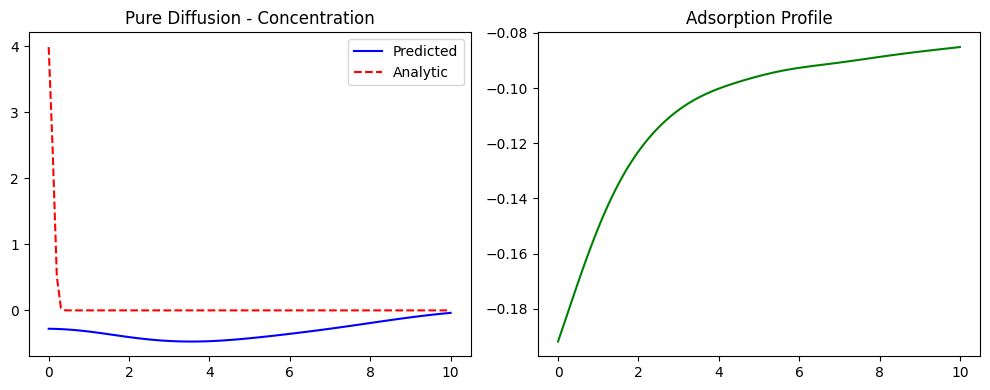


=== Training Adsorption Scenario ===
Epoch 0: Loss = 0.0308
Epoch 200: Loss = 0.0000
Epoch 400: Loss = 0.0000
Epoch 600: Loss = 0.0000
Epoch 800: Loss = 0.0000
Epoch 1000: Loss = 0.0000
Epoch 1200: Loss = 0.0000
Epoch 1400: Loss = 0.0000
Epoch 1600: Loss = 0.0000
Epoch 1800: Loss = 0.0000


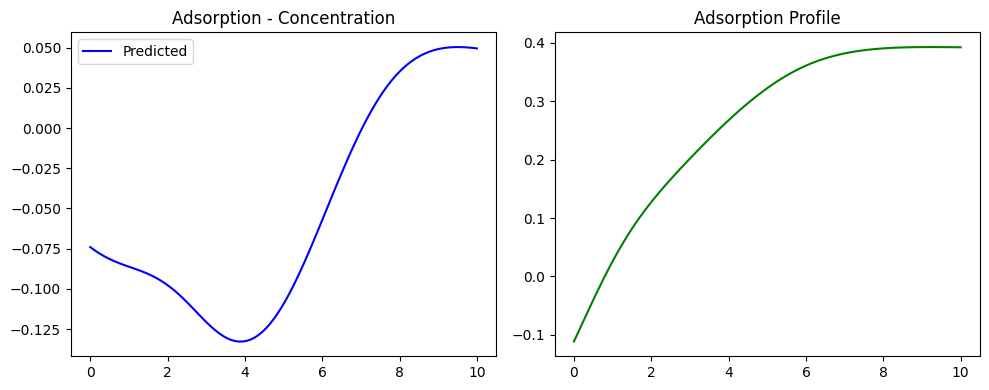


=== Training Interfacial Transfer Scenario ===
Epoch 0: Loss = 0.0300
Epoch 200: Loss = 0.0000
Epoch 400: Loss = 0.0000
Epoch 600: Loss = 0.0000
Epoch 800: Loss = 0.0000
Epoch 1000: Loss = 0.0000
Epoch 1200: Loss = 0.0000
Epoch 1400: Loss = 0.0000
Epoch 1600: Loss = 0.0000
Epoch 1800: Loss = 0.0000


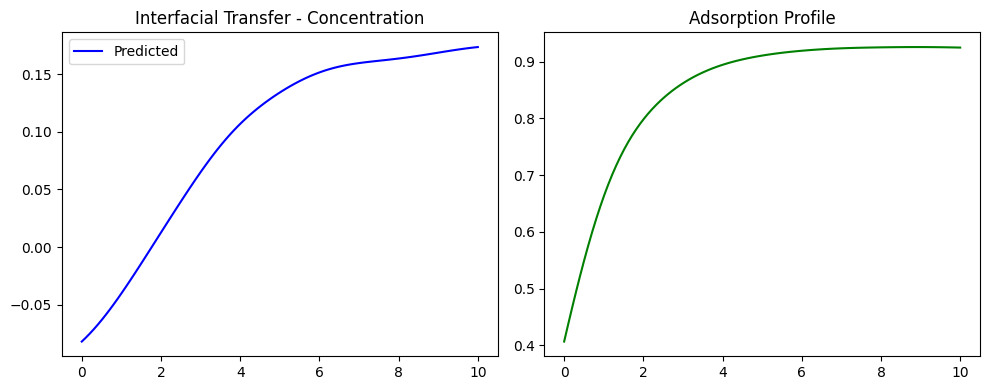

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from scipy.special import erf

# ======================
# Core PINN Components (Your Existing Code)
# ======================

class Tanh(torch.nn.Module):
    def forward(self, x):
        return torch.tanh(x)

class EnhancedHgPINN(torch.nn.Module):
    def __init__(self, num_velocities=9, hidden_size=64):
        super().__init__()
        self.Q = num_velocities
        self.NN_eq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )
        self.NN_neq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, self.Q)
        )
        self.NN_Gamma = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, hidden_size), Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.xi = torch.tensor([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                               [1,1], [-1,1], [-1,-1], [1,-1]], dtype=torch.float32)

    def forward(self, x):
        C = self.NN_eq(x)
        Gamma = self.NN_Gamma(x)
        f_neq = self.NN_neq(x)
        return C, Gamma, f_neq

class PhysicsConstraints:
    def __init__(self, pinn, params):
        self.pinn = pinn
        self.tau = params['tau']
        self.k_a = params['k_a']
        self.k_d = params['k_d']
        self.Gamma_inf = params['Gamma_inf']
        self.C_in = params['C_in']
        self.L = params['L']

    def compute_residuals(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        C, Gamma, f_neq = self.pinn(inputs)
        dC_dx = grad(C, x, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dC_dt = grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dGamma_dt = grad(Gamma, t, grad_outputs=torch.ones_like(Gamma), create_graph=True)[0]
        u = self.pinn.xi[:, 0].reshape(1, -1)

        # Compute derivatives for f_neq
        df_neq_dx, df_neq_dt = [], []
        for i in range(self.pinn.Q):
            df_neq_dx.append(grad(f_neq[:, i].sum(), x, create_graph=True)[0])
            df_neq_dt.append(grad(f_neq[:, i].sum(), t, create_graph=True)[0])

        df_neq_dx = torch.cat(df_neq_dx, dim=1)
        df_neq_dt = torch.cat(df_neq_dt, dim=1)

        S_raw = self.k_a*C*(self.Gamma_inf - Gamma) - self.k_d*Gamma
        S = self.pinn.w * S_raw
        residual = df_neq_dt + u * df_neq_dx + (1/self.tau)*f_neq + S
        Gamma_res = dGamma_dt - S_raw
        return residual, Gamma_res, C, Gamma, f_neq

class HybridOptimizer:
    def __init__(self, pinn, physics, params):
        self.pinn = pinn
        self.physics = physics
        self.params = params

    def adam_phase(self):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for epoch in range(self.params['adam_epochs']):
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            optimizer.step()
            if epoch % 200 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    def compute_total_loss(self):
        # Collocation and boundary points setup
        x_col = torch.rand((1000,1), requires_grad=True) * self.params['L']
        t_col = torch.rand((1000,1), requires_grad=True) * self.params['T']
        residual, Gamma_res, C, Gamma, f_neq = self.physics.compute_residuals(x_col, t_col)
        L_eq = torch.mean(residual**2)
        L_Gamma = torch.mean(Gamma_res**2)
        return 0.3*L_eq + 0.2*L_Gamma

# ======================
# Scenario Simulation Code (Integrated)
# ======================

def run_scenario(scenario_name, params):
    pinn = EnhancedHgPINN()
    physics = PhysicsConstraints(pinn, params)
    optimizer = HybridOptimizer(pinn, physics, params)

    print(f"\n=== Training {scenario_name} Scenario ===")
    optimizer.adam_phase()

    # Generate predictions
    x = torch.linspace(0, params['L'], 100).reshape(-1,1)
    t = torch.ones_like(x) * params['T']
    inputs = torch.cat([x, t], dim=1)
    with torch.no_grad():
        C_pred, Gamma_pred, _ = pinn(inputs)

    # Plot results
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(x.numpy(), C_pred.numpy(), 'b-', label='Predicted')
    if scenario_name == "Pure Diffusion":
        analytic = (params['M']/np.sqrt(4*np.pi*params['D']*params['T'])) * np.exp(-x.numpy()**2/(4*params['D']*params['T']))
        plt.plot(x.numpy(), analytic, 'r--', label='Analytic')
    plt.title(f'{scenario_name} - Concentration')
    plt.legend()

    plt.subplot(122)
    plt.plot(x.numpy(), Gamma_pred.numpy(), 'g-')
    plt.title('Adsorption Profile')
    plt.tight_layout()
    plt.show()

# ======================
# Main Execution
# ======================

if __name__ == "__main__":
    # Scenario 1: Pure Diffusion
    run_scenario("Pure Diffusion", {
        'tau': 0.6, 'k_a': 0, 'k_d': 0,  # Disable adsorption
        'Gamma_inf': 1.8, 'C_in': 1.0,
        'L': 10.0, 'T': 5.0, 'D': 1e-3, 'M': 1.0,
        'adam_epochs': 2000
    })

    # Scenario 2: Adsorption
    run_scenario("Adsorption", {
        'tau': 0.6, 'k_a': 0.15, 'k_d': 0.02,
        'Gamma_inf': 1.8, 'C_in': 1.0,
        'L': 10.0, 'T': 5.0, 'adam_epochs': 2000
    })

    # Scenario 3: Interfacial Transfer
    run_scenario("Interfacial Transfer", {
        'tau': 0.6, 'k_a': 0.15, 'k_d': 0.02,
        'Gamma_inf': 1.8, 'C_in': 1.0,
        'L': 10.0, 'T': 5.0, 'D_liq': 1e-3, 'D_sol': 1e-4,
        'adam_epochs': 2000
    })

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# ======================
# Enhanced Architecture with Phase Awareness
# ======================
class ScenarioAwarePINN(torch.nn.Module):
    def __init__(self, num_velocities=9, hidden_size=64):
        super().__init__()
        self.Q = num_velocities

        # Shared encoder for spatial-temporal features
        self.shared_encoder = torch.nn.Sequential(
            torch.nn.Linear(3, hidden_size),  # [x, t, phase]
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh()
        )

        # Phase-specific networks
        self.NN_eq = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )

        self.NN_neq = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, self.Q)
        )

        self.NN_adsorption = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Sigmoid()  # Constrain Gamma between 0-1
        )

        # D2Q9 parameters
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.xi = torch.tensor([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                               [1,1], [-1,1], [-1,-1], [1,-1]], dtype=torch.float32)

    def forward(self, x, phase):
        # phase: 0=liquid, 1=solid
        encoded = self.shared_encoder(torch.cat([x, phase], dim=1))
        C = self.NN_eq(encoded)
        Gamma = self.NN_adsorption(encoded) * phase  # Only active in solid
        f_neq = self.NN_neq(encoded)
        return C, Gamma, f_neq

# ======================
# Enhanced Physics Constraints
# ======================
class MercuryPhysics:
    def __init__(self, pinn, params):
        self.pinn = pinn
        self.params = params
        self.phase_masks = {'liquid': 0.0, 'solid': 1.0}

    def compute_residuals(self, x, t, phase):
        phase_tensor = torch.full_like(x, self.phase_masks[phase])
        C, Gamma, f_neq = self.pinn(torch.cat([x, t], dim=1), phase_tensor)

        # Common derivatives
        dC_dx = grad(C, x, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dC_dt = grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

        # Phase-dependent parameters
        D = self.params['D_liq'] if phase == 'liquid' else self.params['D_sol']
        u = self.pinn.xi[:,0].reshape(1,-1) * (1 - phase_tensor)  # Only liquid has flow

        # Compute f_neq derivatives
        df_neq_dx, df_neq_dt = [], []
        for i in range(self.pinn.Q):
            df_neq_dx.append(grad(f_neq[:,i].sum(), x, create_graph=True)[0])
            df_neq_dt.append(grad(f_neq[:,i].sum(), t, create_graph=True)[0])

        df_neq_dx = torch.stack(df_neq_dx, dim=1)
        df_neq_dt = torch.stack(df_neq_dt, dim=1)

        # Source terms
        S = torch.zeros_like(f_neq)
        if phase == 'solid':
            S_raw = (self.params['k_a']*C*(1 - Gamma) - self.params['k_d']*Gamma)
            S = self.pinn.w * S_raw

        residual = df_neq_dt + u*df_neq_dx + (1/self.params['tau'])*f_neq + S
        Gamma_res = (grad(Gamma, t, grad_outputs=torch.ones_like(Gamma), create_graph=True)[0]
                     - S_raw) if phase == 'solid' else torch.zeros_like(C)

        return residual, Gamma_res, C, Gamma, f_neq

# ======================
# Scenario-Specific Training
# ======================
class ScenarioTrainer:
    def __init__(self, params):
        self.pinn = ScenarioAwarePINN()
        self.physics = MercuryPhysics(self.pinn, params)
        self.params = params

    def train_scenario(self, scenario):
        if scenario == 1:
            self._train_pure_diffusion()
        elif scenario == 2:
            self._train_adsorption()
        elif scenario == 3:
            self._train_interface()

    def _train_pure_diffusion(self):
        # Freeze adsorption network
        for param in self.pinn.NN_adsorption.parameters():
            param.requires_grad = False

        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for epoch in range(self.params['epochs']):
            # Create inputs WITH GRADIENT TRACKING
            x = torch.rand((1000,1), requires_grad=True) * self.params['L_liq']  # Fix 1
            t = torch.rand((1000,1), requires_grad=True) * self.params['T']     # Fix 2

            # Compute residuals with proper gradient propagation
            residual, _, C, _, _ = self.physics.compute_residuals(x, t, 'liquid')

            # Remove Gamma-related terms from loss
            loss = torch.mean(residual**2)  # Focus only on fluid dynamics

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    def _train_adsorption(self):
        # Sample points in solid phase with adsorption
        def loss_fn():
            x = torch.rand((500,1)) * self.params['L_sol']
            t = torch.rand((500,1)) * self.params['T']
            residual, Gamma_res, _, _, _ = self.physics.compute_residuals(x, t, 'solid')
            return torch.mean(residual**2) + torch.mean(Gamma_res**2)

        self._optimize(loss_fn)

    def _train_interface(self):
        def loss_fn():
            # Liquid phase loss
            x_liq = torch.rand((500,1)) * self.params['L_liq']
            t_liq = torch.rand((500,1)) * self.params['T']
            res_liq, _, _, _, _ = self.physics.compute_residuals(x_liq, t_liq, 'liquid')

            # Solid phase loss
            x_sol = torch.rand((500,1)) * self.params['L_sol'] + self.params['L_liq']
            t_sol = torch.rand((500,1)) * self.params['T']
            res_sol, Gamma_res, _, _, _ = self.physics.compute_residuals(x_sol, t_sol, 'solid')

            # Interface coupling
            x_int = torch.full((100,1), self.params['L_liq'])
            C_liq = self.pinn(torch.cat([x_int, torch.zeros_like(x_int)], dim=1),
                            torch.zeros_like(x_int))[0]
            C_sol = self.pinn(torch.cat([x_int, torch.zeros_like(x_int)], dim=1),
                            torch.ones_like(x_int))[0]
            interface_loss = torch.mean((C_liq - C_sol)**2)

            return (torch.mean(res_liq**2) + torch.mean(res_sol**2)
                    + torch.mean(Gamma_res**2) + interface_loss)

        self._optimize(loss_fn)

    def _optimize(self, loss_fn):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for epoch in range(self.params['epochs']):
            loss = loss_fn()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# ======================
# Parameter Setup & Execution
# ======================
params = {
    'tau': 0.6,
    'k_a': 0.15,
    'k_d': 0.02,
    'D_liq': 1e-3,
    'D_sol': 1e-4,
    'L_liq': 5.0,
    'L_sol': 5.0,
    'T': 5.0,
    'epochs': 2000
}

trainer = ScenarioTrainer(params)

# Run scenario 1: Pure diffusion
print("Training Pure Diffusion Scenario...")
trainer.train_scenario(1)

# Run scenario 2: Adsorption
print("\nTraining Adsorption Scenario...")
trainer.train_scenario(2)

# Run scenario 3: Interfacial Transfer
print("\nTraining Interfacial Transfer Scenario...")
trainer.train_scenario(3)


Training Pure Diffusion Scenario...


RuntimeError: The size of tensor a (1000) must match the size of tensor b (9) at non-singleton dimension 1

===> Initial Parameter Stats:
NN_eq.0.weight: mean=-0.00416, std=0.39887
NN_eq.0.bias: mean=-0.02632, std=0.41273
NN_eq.2.weight: mean=-0.00062, std=0.07207
NN_eq.2.bias: mean=-0.00475, std=0.06860
NN_eq.4.weight: mean=0.00401, std=0.06230
NN_eq.4.bias: mean=0.08005, std=nan
NN_neq.0.weight: mean=0.00095, std=0.40064
NN_neq.0.bias: mean=-0.09678, std=0.37054
NN_neq.2.weight: mean=-0.00056, std=0.07229
NN_neq.2.bias: mean=-0.00262, std=0.07210
NN_neq.4.weight: mean=0.00006, std=0.07249
NN_neq.4.bias: mean=-0.02577, std=0.07876
NN_Gamma.0.weight: mean=0.00116, std=0.42130
NN_Gamma.0.bias: mean=-0.06314, std=0.42238
NN_Gamma.2.weight: mean=-0.00219, std=0.07182
NN_Gamma.2.bias: mean=-0.00088, std=0.08181
NN_Gamma.4.weight: mean=-0.00860, std=0.07502
NN_Gamma.4.bias: mean=-0.00509, std=nan

Starting Adam phase...
[Adam Epoch 0] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]


<ipython-input-3-067299318e09>:249: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.data.mean():.5f}, std={param.data.std():.5f}")


[Adam Epoch 200] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 400] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 600] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 800] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 1000] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 1200] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 1400] loss = nan
  x_test: [0.0, 5.0, 10.0]
  t_test: [0.0, 2.5, 5.0]
  C_test: [nan, nan, nan]
  Gamma_test: [nan, nan, nan]
[Adam Epoch 1600] loss = nan
  x_test:

<ipython-input-3-067299318e09>:263: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.data.mean():.5f}, std={param.data.std():.5f}")


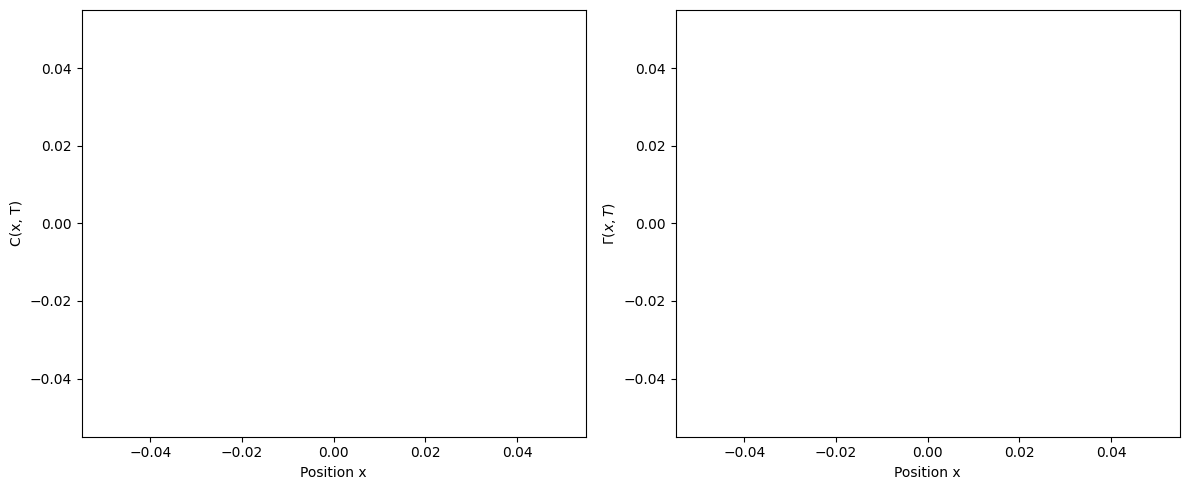

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from scipy.optimize import minimize

# ======================
# Custom Activation
# ======================
class Sinh(torch.nn.Module):
    def forward(self, x):
        return torch.sinh(x)

# ======================
# Enhanced PINN Architecture
# ======================
class EnhancedHgPINN(torch.nn.Module):
    def __init__(self, num_velocities=9, hidden_size=64):
        super().__init__()
        self.Q = num_velocities

        # Subnetworks
        self.NN_eq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, 1)
        )

        self.NN_neq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, self.Q)
        )

        self.NN_Gamma = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, 1)
        )

        # D2Q9 lattice parameters
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.xi = torch.tensor([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                                [1,1], [-1,1], [-1,-1], [1,-1]], dtype=torch.float32)

    def forward(self, x):
        """
        x is a 2D Tensor [batch_size, 2] with columns [x, t].
        Returns: C (scalar), Gamma (scalar), f_neq (vector of length Q).
        """
        C = self.NN_eq(x)
        Gamma = self.NN_Gamma(x)
        f_neq = self.NN_neq(x)
        return C, Gamma, f_neq

# ======================
# Physics Constraints
# ======================
class PhysicsConstraints:
    def __init__(self, pinn, params):
        self.pinn = pinn
        self.tau = params['tau']
        self.k_a = params['k_a']
        self.k_d = params['k_d']
        self.Gamma_inf = params['Gamma_inf']
        self.C_in = params['C_in']
        self.L = params['L']

    def compute_residuals(self, x, t):
        """
        x, t: [N,1] Tensors with requires_grad=True.
        """
        inputs = torch.cat([x, t], dim=1).requires_grad_(True)
        C, Gamma, f_neq = self.pinn(inputs)

        # Derivatives (w.r.t. x, t)
        dC_dx = grad(C, x, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dC_dt = grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dGamma_dt = grad(Gamma, t, grad_outputs=torch.ones_like(Gamma), create_graph=True)[0]

        # Since this is 1D in x, we'll only use xi_x:
        u = self.pinn.xi[:,0].reshape(1, -1)  # shape [1, 9]

        # Derivatives of f_neq
        df_neq_dx = grad(f_neq, x, grad_outputs=torch.ones_like(f_neq), create_graph=True)[0]
        df_neq_dt = grad(f_neq, t, grad_outputs=torch.ones_like(f_neq), create_graph=True)[0]

        # Source term
        # shape of w: [9], broadcast to [N,9]
        S = self.pinn.w * (self.k_a * C * (self.Gamma_inf - Gamma) - self.k_d * Gamma)
        S = S.unsqueeze(1)  # shape [N, 1] -> [N, 9]

        # Residual for f_neq transport in 1D:
        # df/dt + u * df/dx + relaxation + source
        residual = (
            df_neq_dt
            + u * df_neq_dx
            - (-1/self.tau)*f_neq
            + S
        )

        # Residual for Gamma evolution
        Gamma_res = dGamma_dt - (self.k_a * C * (self.Gamma_inf - Gamma) - self.k_d * Gamma)

        return residual, Gamma_res, C, Gamma, f_neq

# ======================
# Hybrid Optimizer
# ======================
class HybridOptimizer:
    def __init__(self, pinn, physics, params):
        self.pinn = pinn
        self.physics = physics
        self.params = params

    def adam_phase(self):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for epoch_i in range(self.params['adam_epochs']):
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            optimizer.step()

            # Debug print every 200 epochs (you can adjust frequency)
            if epoch_i % 200 == 0:
                print(f"[Adam Epoch {epoch_i}] loss = {loss.item():.6f}")
                # Print sample predictions
                with torch.no_grad():
                    x_test = torch.tensor([[0.0],[self.params['L']/2],[self.params['L']]])
                    t_test = torch.tensor([[0.0],[self.params['T']/2],[self.params['T']]])
                    inputs_test = torch.cat([x_test, t_test], dim=1)
                    C_test, Gamma_test, _ = self.pinn(inputs_test)
                    print("  x_test:", x_test.view(-1).tolist())
                    print("  t_test:", t_test.view(-1).tolist())
                    print("  C_test:", C_test.view(-1).tolist())
                    print("  Gamma_test:", Gamma_test.view(-1).tolist())

    def lbfgs_phase(self):
        optimizer = torch.optim.LBFGS(
            self.pinn.parameters(),
            max_iter=self.params['lbfgs_iter'],
            history_size=50,
            line_search_fn='strong_wolfe'
        )

        def closure():
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            return loss

        optimizer.step(closure)

    def compute_total_loss(self):
        # Collocation points
        x_col = torch.rand((1000,1), requires_grad=True) * self.params['L']
        t_col = torch.rand((1000,1), requires_grad=True) * self.params['T']

        # Boundary points
        x_inlet = torch.zeros((200,1), requires_grad=True)
        t_inlet = torch.rand((200,1), requires_grad=True) * self.params['T']
        x_outlet = torch.ones((200,1), requires_grad=True) * self.params['L']
        t_outlet = torch.rand((200,1), requires_grad=True) * self.params['T']

        # Initial conditions
        x_ic = torch.rand((500,1), requires_grad=True) * self.params['L']
        t_ic = torch.zeros((500,1), requires_grad=True)

        # Synthetic data points
        x_data = torch.rand((300,1)) * self.params['L']
        t_data = torch.rand((300,1)) * self.params['T']
        # Example synthetic "exact" C
        C_data = torch.exp(-x_data**2) * torch.sin(2*np.pi*t_data/self.params['T']).squeeze()

        # Residuals
        residual, Gamma_res, C_col, Gamma_col, f_neq_col = self.physics.compute_residuals(x_col, t_col)

        # Data mismatch
        inputs_data = torch.cat([x_data, t_data], dim=1)
        C_data_pred, Gamma_data_pred, _ = self.pinn(inputs_data)
        C_data_pred = C_data_pred.squeeze()

        # Loss components
        L_eq = torch.mean(residual**2)
        L_Gamma = torch.mean(Gamma_res**2)
        L_ic = self.initial_condition_loss(x_ic, t_ic)
        L_bc = self.boundary_loss(x_inlet, t_inlet, x_outlet, t_outlet)
        L_data = torch.mean((C_data_pred - C_data)**2)

        # Weighted sum
        return 0.3*L_eq + 0.2*L_Gamma + 0.2*L_ic + 0.2*L_bc + 0.1*L_data

    def initial_condition_loss(self, x, t):
        # For instance, we want zero initial condition, or something similar
        inputs = torch.cat([x, t], dim=1)
        C, Gamma, f_neq = self.pinn(inputs)
        return torch.mean(C**2) + torch.mean(Gamma**2) + torch.mean(f_neq**2)

    def boundary_loss(self, x_inlet, t_inlet, x_outlet, t_outlet):
        # Inlet boundary (Dirichlet)
        inputs_in = torch.cat([x_inlet, t_inlet], dim=1)
        C_in, _, _ = self.pinn(inputs_in)
        L_inlet = torch.mean((C_in - self.params['C_in'])**2)

        # Outlet boundary (Neumann: dC/dx=0)
        inputs_out = torch.cat([x_outlet, t_outlet], dim=1)
        C_out, _, _ = self.pinn(inputs_out)
        dC_dx = grad(C_out, x_outlet,
                     grad_outputs=torch.ones_like(C_out),
                     create_graph=True)[0]
        L_outlet = torch.mean(dC_dx**2)

        return 0.7*L_inlet + 0.3*L_outlet


# ======================
# Simulation Parameters
# ======================
sim_params = {
    'tau': 0.6,
    'k_a': 0.15,
    'k_d': 0.02,
    'Gamma_inf': 1.8,
    'C_in': 1.0,
    'L': 10.0,
    'T': 5.0,
    'adam_epochs': 2000,
    'lbfgs_iter': 500
}

# ======================
# Main Simulation
# ======================
def main():
    # 1) Instantiate PINN and physics
    pinn = EnhancedHgPINN()
    physics = PhysicsConstraints(pinn, sim_params)
    optimizer = HybridOptimizer(pinn, physics, sim_params)

    # 2) Show initial parameter stats
    print("===> Initial Parameter Stats:")
    for name, param in pinn.named_parameters():
        print(f"{name}: mean={param.data.mean():.5f}, std={param.data.std():.5f}")
    print()

    # 3) Adam optimization phase
    print("Starting Adam phase...")
    optimizer.adam_phase()

    # 4) L-BFGS optimization phase
    print("\nStarting L-BFGS phase...")
    optimizer.lbfgs_phase()

    # 5) Show final parameter stats
    print("\n===> Final Parameter Stats:")
    for name, param in pinn.named_parameters():
        print(f"{name}: mean={param.data.mean():.5f}, std={param.data.std():.5f}")

    # 6) Visualization with unnormalized inputs
    x_plot = torch.linspace(0, sim_params['L'], 100).reshape(-1,1)  # [0..10]
    t_plot = torch.ones_like(x_plot) * sim_params['T']              # T=5
    inputs_plot = torch.cat([x_plot, t_plot], dim=1)
    with torch.no_grad():
        C_plot, Gamma_plot, _ = pinn(inputs_plot)

    # Plot
    plt.figure(figsize=(12,5))

    # Plot Concentration
    plt.subplot(121)
    plt.plot(x_plot.numpy(), C_plot.numpy(), label='Concentration')
    plt.xlabel('Position x')
    plt.ylabel('C(x, T)')

    # Plot Adsorption
    plt.subplot(122)
    plt.plot(x_plot.numpy(), Gamma_plot.numpy(), label='Adsorption')
    plt.xlabel('Position x')
    plt.ylabel(r'$\Gamma(x, T)$')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Starting Adam phase...
Starting L-BFGS phase...


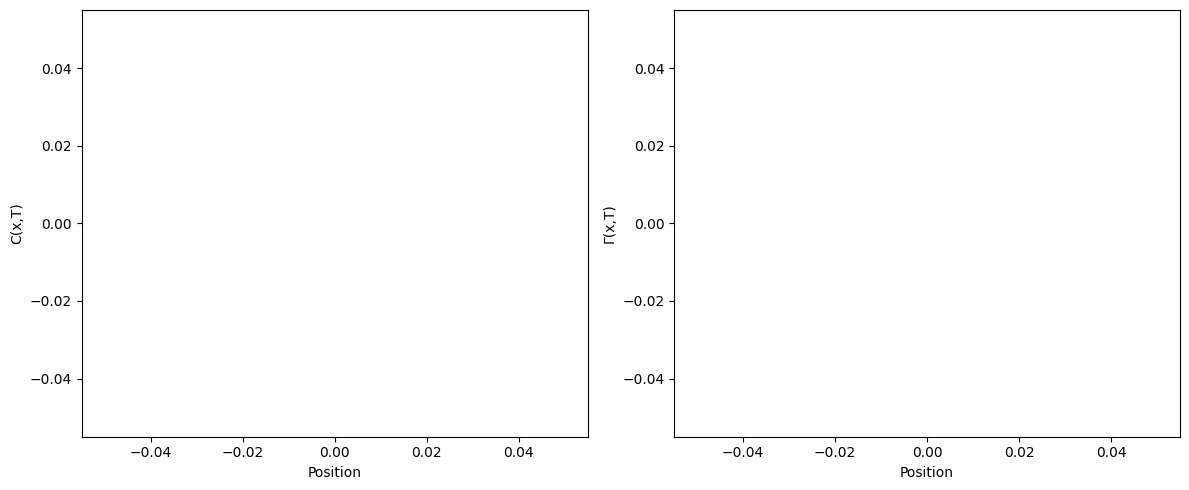

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from scipy.optimize import minimize

# ======================
# Custom Activation
# ======================
class Sinh(torch.nn.Module):
    def forward(self, x):
        return torch.sinh(x)

# ======================
# Enhanced PINN Architecture
# ======================
class EnhancedHgPINN(torch.nn.Module):
    def __init__(self, num_velocities=9, hidden_size=64):
        super().__init__()
        self.Q = num_velocities

        # Subnetworks
        self.NN_eq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, 1)
        )

        self.NN_neq = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, self.Q)
        )

        self.NN_Gamma = torch.nn.Sequential(
            torch.nn.Linear(2, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, hidden_size),
            Sinh(),
            torch.nn.Linear(hidden_size, 1)
        )

        # D2Q9 lattice
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.xi = torch.tensor([[0,0], [1,0], [0,1], [-1,0], [0,-1],
                               [1,1], [-1,1], [-1,-1], [1,-1]], dtype=torch.float32)

    def forward(self, x):
        C = self.NN_eq(x)
        Gamma = self.NN_Gamma(x)
        f_neq = self.NN_neq(x)
        return C, Gamma, f_neq

# ======================
# Physics Constraints
# ======================
class PhysicsConstraints:
    def __init__(self, pinn, params):
        self.pinn = pinn
        self.tau = params['tau']
        self.k_a = params['k_a']
        self.k_d = params['k_d']
        self.Gamma_inf = params['Gamma_inf']
        self.C_in = params['C_in']
        self.L = params['L']

    def compute_residuals(self, x, t):
        inputs = torch.cat([x, t], dim=1).requires_grad_(True)
        C, Gamma, f_neq = self.pinn(inputs)

        # Derivatives
        dC_dx = grad(C, x, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dC_dt = grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        dGamma_dt = grad(Gamma, t, grad_outputs=torch.ones_like(Gamma), create_graph=True)[0]

        # Velocity components - FIXED SHAPE
        u = self.pinn.xi[:,0].reshape(1, -1)  # Shape [1,9]
        v = self.pinn.xi[:,1].reshape(1, -1)   # Shape [1,9]

        # Non-equilibrium derivatives - FIXED DIMENSIONS
        df_neq_dx = grad(f_neq, x,
                        grad_outputs=torch.ones_like(f_neq),
                        create_graph=True)[0]  # Shape [1000,9]

        df_neq_dt = grad(f_neq, t,
                        grad_outputs=torch.ones_like(f_neq),
                        create_graph=True)[0]  # Shape [1000,9]

        # Source term - FIXED BROADCASTING
        S = self.pinn.w * (self.k_a * C * (self.Gamma_inf - Gamma) - self.k_d * Gamma)
        S = S.unsqueeze(1)  # Shape [1000,1] -> [1000,9]

        # Residual calculations - FIXED OPERATION
        residual = (
            df_neq_dt
            + u * df_neq_dx
            + v * df_neq_dx  # For 1D flow, use only x-components
            - (-1/self.tau)*f_neq
            + S
        )

        Gamma_res = dGamma_dt - (self.k_a * C * (self.Gamma_inf - Gamma) - self.k_d * Gamma)

        return residual, Gamma_res, C, Gamma, f_neq


# ======================
# Hybrid Optimizer
# ======================
class HybridOptimizer:
    def __init__(self, pinn, physics, params):
        self.pinn = pinn
        self.physics = physics
        self.params = params
        self.epoch = 0

    def adam_phase(self):
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=0.001)
        for _ in range(self.params['adam_epochs']):
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            optimizer.step()
            self.epoch += 1

    def lbfgs_phase(self):
        optimizer = torch.optim.LBFGS(self.pinn.parameters(),
                                    max_iter=self.params['lbfgs_iter'],
                                    history_size=100,
                                    line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()
            loss = self.compute_total_loss()
            loss.backward()
            return loss

        optimizer.step(closure)

    def compute_total_loss(self):
        # Collocation points with gradient tracking
        x_col = torch.rand((1000,1), requires_grad=True) * self.params['L']
        t_col = torch.rand((1000,1), requires_grad=True) * self.params['T']

        # Boundary points with gradient tracking
        x_inlet = torch.zeros((200,1), requires_grad=True)
        t_inlet = torch.rand((200,1), requires_grad=True) * self.params['T']
        x_outlet = torch.ones((200,1), requires_grad=True) * self.params['L']
        t_outlet = torch.rand((200,1), requires_grad=True) * self.params['T']

        # Initial conditions with gradient tracking
        x_ic = torch.rand((500,1), requires_grad=True) * self.params['L']
        t_ic = torch.zeros((500,1), requires_grad=True)

        # Data points (no gradient needed)
        x_data = torch.rand((300,1)) * self.params['L']
        t_data = torch.rand((300,1)) * self.params['T']
        C_data = torch.exp(-x_data**2) * torch.sin(2*np.pi*t_data/self.params['T']).squeeze()

        # Compute residuals
        residual, Gamma_res, C_col, Gamma_col, f_neq_col = self.physics.compute_residuals(x_col, t_col)

        # Data loss calculation
        inputs_data = torch.cat([x_data, t_data], dim=1)
        C_data_pred, Gamma_data, _ = self.pinn(inputs_data)
        C_data_pred = C_data_pred.squeeze()

        # Loss components
        L_eq = torch.mean(residual**2)
        L_Gamma = torch.mean(Gamma_res**2)
        L_ic = self.initial_condition_loss(x_ic, t_ic)
        L_bc = self.boundary_loss(x_inlet, t_inlet, x_outlet, t_outlet)
        L_data = torch.mean((C_data_pred - C_data)**2)

        return 0.3*L_eq + 0.2*L_Gamma + 0.2*L_ic + 0.2*L_bc + 0.1*L_data

    def initial_condition_loss(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        C, Gamma, f_neq = self.pinn(inputs)
        return torch.mean(C**2) + torch.mean(Gamma**2) + torch.mean(f_neq**2)

    def boundary_loss(self, x_inlet, t_inlet, x_outlet, t_outlet):
        # Inlet boundary (Dirichlet)
        inputs_in = torch.cat([x_inlet, t_inlet], dim=1)
        C_in, _, _ = self.pinn(inputs_in)
        L_inlet = torch.mean((C_in - self.params['C_in'])**2)

        # Outlet boundary (Neumann)
        inputs_out = torch.cat([x_outlet, t_outlet], dim=1)
        C_out, _, _ = self.pinn(inputs_out)
        dC_dx = grad(C_out, x_outlet,
                   grad_outputs=torch.ones_like(C_out),
                   create_graph=True)[0]
        L_outlet = torch.mean(dC_dx**2)

        return 0.7*L_inlet + 0.3*L_outlet

# ======================
# Simulation Parameters
# ======================
sim_params = {
    'tau': 0.6,
    'k_a': 0.15,
    'k_d': 0.02,
    'Gamma_inf': 1.8,
    'C_in': 1.0,
    'L': 10.0,
    'T': 5.0,
    'adam_epochs': 2000,
    'lbfgs_iter': 500
}

# ======================
# Main Simulation
# ======================
def main():
    pinn = EnhancedHgPINN()
    physics = PhysicsConstraints(pinn, sim_params)
    optimizer = HybridOptimizer(pinn, physics, sim_params)

    print("Starting Adam phase...")
    optimizer.adam_phase()

    print("Starting L-BFGS phase...")
    optimizer.lbfgs_phase()

    # Visualization (Normalized Inputs)
    x = torch.linspace(0, sim_params['L'], 100).reshape(-1,1) / sim_params['L']
    t = (torch.ones(100,1) * sim_params['T']) / sim_params['T']

    inputs = torch.cat([x, t], dim=1)
    C, Gamma, _ = pinn(inputs)

    plt.figure(figsize=(12,5))

    # Plot Concentration
    plt.subplot(121)
    plt.plot(x.detach().numpy(), C.detach().numpy(), label='Concentration')
    plt.xlabel('Position')
    plt.ylabel('C(x,T)')

    # Plot Adsorption
    plt.subplot(122)
    plt.plot(x.detach().numpy(), Gamma.detach().numpy(), label='Adsorption')
    plt.xlabel('Position')
    plt.ylabel('Γ(x,T)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()